# Notebook Jepirachi
Estimación de la producción de energía del parque Jepirachi a partir de datos de viento disponibles.

<br>

Tesis de Maestría - Alejandro Pulido Castro - 201616792

Enero 2023

In [ ]:
import json, os
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from windrose import WindroseAxes
import matplotlib.cm as cm
from operator import itemgetter

from numpy import sin, cos, log, exp, sqrt, radians

#### Importación de datos del parque Jepirachi.

Se tienen disponibles datos para todo el año 2019, incluyendo potencia y velocidad diezminutal medida en cada turbina, además de datos de velocidad de viento, dirección y desviación estándar diezminutal medida en una torre metereológica.

In [4]:
datos_Pot_Vel = pd.read_excel(r"E:\Documents\ORGANIZADO\Tesis Eólica\DatosJepirachi\Potencia_MedGondola\2019 POTENCIA ACTIVA & VELOCIDAD VIENTO.xlsx")

datos_Pot_Vel.drop(columns=['tstamp'], inplace=True)
datos_Pot_Vel.rename(columns={'FECHA' : 'Fecha'}, inplace=True)
datos_Pot_Vel.rename(columns={'AG 08 POTENCIA ACTIVA KW' : 'AG08 POTENCIA ACTIVA KW'}, inplace=True)


for i in range(15): #numero turbinas
    
    datos_Pot_Vel.rename(columns=dict({'AG{:02} VELOCIDAD VIENTO m/s'.format(i+1) :'Vel_{}'.format(i+1)}), inplace=True)
    vels = datos_Pot_Vel[datos_Pot_Vel.columns[datos_Pot_Vel.columns.str.contains(pat='Vel')]]
    vels = pd.merge(datos_Pot_Vel['Fecha'], vels, left_index=True, right_index=True)

    datos_Pot_Vel.rename(columns=dict({'AG{:02} POTENCIA ACTIVA KW'.format(i+1) :'Pot_{}'.format(i+1)}), inplace=True)
    pots = datos_Pot_Vel[datos_Pot_Vel.columns[datos_Pot_Vel.columns.str.contains(pat='Pot')]]
    pots = pd.merge(datos_Pot_Vel['Fecha'], pots, left_index=True, right_index=True)


In [5]:
datos_granja = pd.read_csv(r"E:\Documents\ORGANIZADO\Tesis Eólica\DatosJepirachi\jepirachi.csv", encoding='latin-1')

def cargar_datos_Jepirachi():
    global diam_turbinas, long_turbinas_m, lat_turbinas_m
    altura_cubo = 60
    diam_turbinas = 60
    alturas_turbina = datos_granja['Altura SNM de base de turbina [m]']

    long_turbinas = datos_granja['Latitud']
    lat_turbinas = datos_granja['Longitud']

    #se convierten las coordenadas a metros
    cero_long = min(long_turbinas)
    cero_lat = min(lat_turbinas)
    long_turbinas_m = [(x - cero_long) * 111320 for x in long_turbinas] #1 degree = 111.32 km
    lat_turbinas_m = [(y - cero_lat) * 111320 for y in lat_turbinas]

cargar_datos_Jepirachi()


In [6]:

#datos turbina Nordex N60 - extraídos de https://en.wind-turbine-models.com/turbines/77-nordex-n60
datos_turbina = pd.read_excel(r"E:\Documents\ORGANIZADO\Tesis Eólica\DatosJepirachi\Datos_Turbina.xlsx")

Vels_N60 = datos_turbina['Vel']
Pot_N60 = datos_turbina['Power (kW)']
C_p_N60 = datos_turbina['Cp']


#datos de las turbinas en Coquito, se necesitan porque no se conoce C_th para las turbinas N60
os.chdir(r'E:\Documents\ORGANIZADO\Tesis Eólica')
with open('system_config_coquito.json') as f:
    datos = json.load(f)

Tipo_Turbina = datos['Turbinas']['Enercon_E92']
Vels = Tipo_Turbina['Velocidades_ms-1']
Pot = Tipo_Turbina['Potencia_kW']
C_th = Tipo_Turbina['C_th']

datos.keys()


dict_keys(['Nombre', 'Turbinas', 'Torres_Meteorologicas', 'Rugosidad', 'Configuracion_Parque', 'Cableado', 'PCC'])

#### Datos Torre Metereológica

De  52561  datos originales, 6335 se perdieron por pérdida de datos de dirección, y 142 por velocidad, dejando un total de 46084 datos


Text(0.5, 1.0, 'Rosa de vientos torre metereológica Jepirachi')

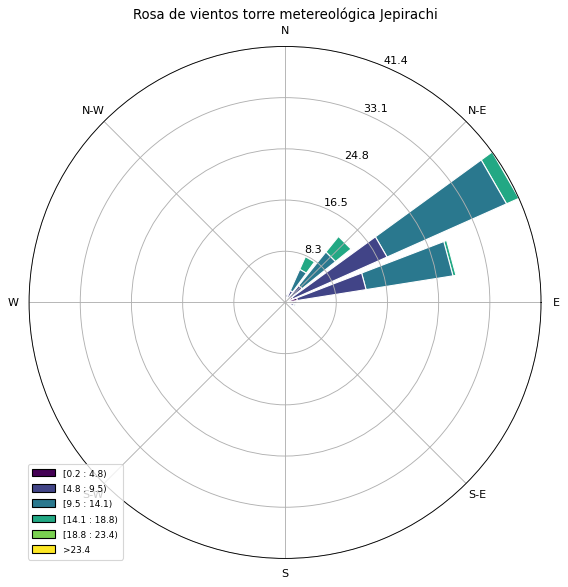

In [8]:
dir_viento = pd.read_csv(r"E:\Documents\ORGANIZADO\Tesis Eólica\DatosJepirachi\TorreMeteorologica Jepirachi\Info Jepirachi\Direccion Viento 80 metros Estacion Jepirachi.txt", sep='\s+', header=None)
dir_viento.drop(columns=[0,1], inplace=True)
dir_viento.columns = ['Fecha', 'Hora', 'Direccion', 'Codigo_dir']
dir_viento['Fecha'] = pd.to_datetime(dir_viento['Fecha'], format = '%Y%m%d')
dir_viento['Hora'] = dir_viento['Hora'] % 100 + (dir_viento['Hora']//100)*60
dir_viento['Fecha'] = dir_viento['Fecha'] + pd.to_timedelta(dir_viento['Hora'], 'm')
dir_viento.drop(columns=['Hora'], inplace=True)




vel_viento = pd.read_csv(r"E:\Documents\ORGANIZADO\Tesis Eólica\DatosJepirachi\TorreMeteorologica Jepirachi\Info Jepirachi\Velocidad Viento 80 metros Estacion Jepirachi.txt", sep='\s+', header=None) #Torre 1
vel_viento.drop(columns=[0,1], inplace=True)
vel_viento.columns = ['Fecha', 'Hora', 'Velocidad', 'Codigo_vel']
vel_viento['Fecha'] = pd.to_datetime(vel_viento['Fecha'], format = '%Y%m%d')
vel_viento['Hora'] = vel_viento['Hora'] % 100 + (vel_viento['Hora']//100)*60
vel_viento['Fecha'] = vel_viento['Fecha'] + pd.to_timedelta(vel_viento['Hora'], 'm')
vel_viento.drop(columns=['Hora'], inplace=True)

datos_torre = pd.merge(dir_viento, vel_viento, how='inner', on=['Fecha'])
org_len = datos_torre.shape[0]


#se eliminan los datos con velocidad o dirección perdida
datos_torre.drop(datos_torre[(datos_torre['Codigo_dir'] == 151) | (datos_torre['Codigo_dir'] == 141) | (datos_torre['Codigo_dir'] == 254) | (datos_torre['Codigo_dir'] == 255)].index, inplace=True)
dir_perdidos = org_len - datos_torre.shape[0]

datos_torre.drop(datos_torre[(datos_torre['Codigo_vel'] == 151) | (datos_torre['Codigo_vel'] == 141) | (datos_torre['Codigo_vel'] == 254) | (datos_torre['Codigo_vel'] == 255)].index, inplace=True)
vel_perdidos = org_len - dir_perdidos - datos_torre.shape[0]

print('De ', org_len, ' datos originales,', dir_perdidos, 'se perdieron por pérdida de datos de dirección, y', vel_perdidos, 
        'por velocidad, dejando un total de', datos_torre.shape[0], 'datos')

# Windrose / Rosa de vientos

ws = datos_torre['Velocidad']
wd = datos_torre['Direccion']

ax = WindroseAxes.from_ax()
ax.bar(wd, ws, nsector= 24,normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
ax.set_title('Rosa de vientos torre metereológica Jepirachi')

Text(0.5, 1.0, 'Rosa de vientos torre metereológica Coquito')

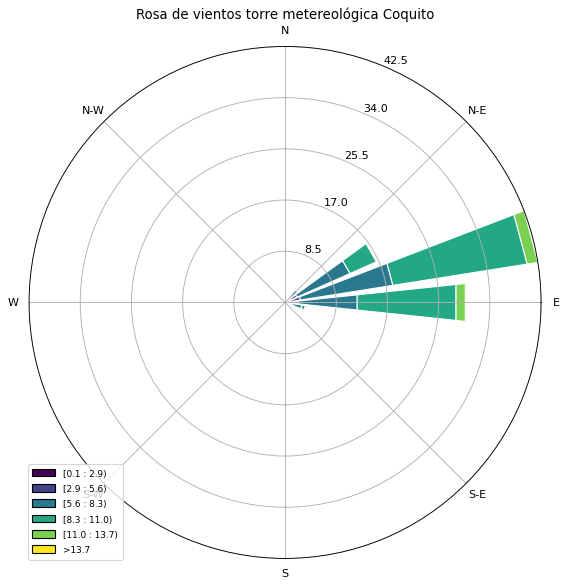

In [9]:
### DATOS COQUITO

datos_viento = pd.read_csv('datos_met_F.csv',skiprows=[0],decimal=',') #Torre 1
vels_coquito = datos_viento['wSpeed_98'].values
dirs_coquito = datos_viento['wDir_98'].values

# Windrose / Rosa de vientos

ws = vels_coquito
wd = dirs_coquito   

ax = WindroseAxes.from_ax()
ax.bar(wd, ws, nsector=24, normed=True, opening=0.8, edgecolor='white')
ax.set_legend()
ax.set_title('Rosa de vientos torre metereológica Coquito')


Text(0.5, 1.0, 'Distribución de ángulos de viento Jepirachi\n $N_{samples} = 46084$')

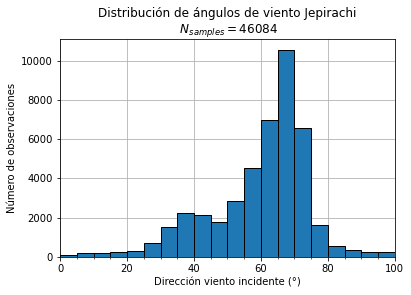

In [10]:
figs, ax = plt.subplots()
ax.grid()
ax.set_axisbelow(True)
ax.hist(datos_torre['Direccion'], bins = 36*2, ec='black')
ax.set_xlim(0,100)
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(5))
ax.set_xlabel('Dirección viento incidente (°)')
ax.set_ylabel('Número de observaciones')
ax.set_title('Distribución de ángulos de viento Jepirachi\n $N_{samples} = 46084$')

Text(0.5, 1.0, 'Distribución de ángulos de viento Jepirachi\n $N_{samples} = 46084$')

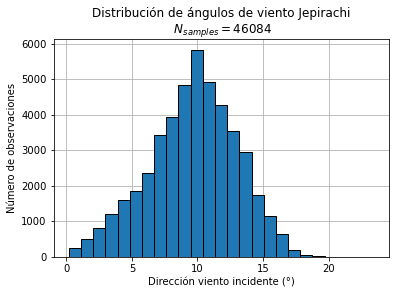

In [11]:
figs, ax = plt.subplots()
ax.grid()
ax.set_axisbelow(True)
ax.hist(datos_torre['Velocidad'], bins = 25, ec='black')
# ax.set_xlim(0,100)
# ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(5))
ax.set_xlabel('Dirección viento incidente (°)')
ax.set_ylabel('Número de observaciones')
ax.set_title('Distribución de ángulos de viento Jepirachi\n $N_{samples} = 46084$')

Text(0.5, 1.0, 'Distribución de ángulos de viento parque Coquito \n $N_{samples} = 87666$')

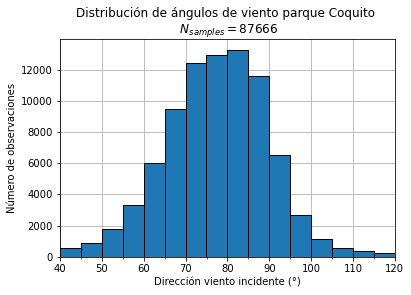

In [12]:
figs, ax = plt.subplots()
ax.grid()
ax.set_axisbelow(True)
ax.hist(dirs_coquito, bins = 36*2, ec='black')
ax.set_xlim(40,120)
ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(5))
ax.set_xlabel('Dirección viento incidente (°)')
ax.set_ylabel('Número de observaciones')
ax.set_title('Distribución de ángulos de viento parque Coquito \n $N_{samples} = 87666$')

#### Funciones auxiliares para los modelos de estela

In [7]:
from numpy import argsort

def ordenar_turbinas(direccion):
    '''
    Retorna una lista con los indices de las turbinas según el orden de incidencia del viento (direccion)
    '''
    x = np.array(long_turbinas_m)
    y = np.array(lat_turbinas_m)
    alpha = np.arctan2(y,x)
    d = sqrt(x**2 + y**2)*cos(alpha - radians(direccion))
    orden = argsort(d)

    return orden


def calcular_Ct(v):
    '''
    Realiza una interpolación para encontrar Ct a partir de la velocidad de entrada
    '''
    return np.interp(v,Vels,C_th)

def interp_pot(v):
    '''
    Realiza una interpolación para encontrar la potencia a partir de la velocidad de entrada
    '''
    return np.interp(v,Vels,Pot)


def pintar_turbinas_ordenadas(direccion, pintar_indices = False):
    '''
    Pinta la granja eólica. 
        Si pintar_indices=False, pinta junto a cada turbina su orden de incidencia según el viento (direccion)
        Si pintar_indices=True, pinta el orden de las turbinas como se encuentra en las listas datos_granja o [long_turbinas_m]
    '''
    n = ordenar_turbinas(direccion)
    fig, ax = plt.subplots(figsize=(5, 5), dpi=200)
    ax.scatter(long_turbinas_m,lat_turbinas_m)
    ax.set_title('Parque Coquito')
    ax.set_xlabel('Longitud [m]')
    ax.set_ylabel('Latitud [m]')
    ax.set_aspect('equal')
    for i, txt in enumerate(n):
        if pintar_indices == False:
            plt.annotate(i, (long_turbinas_m[txt], lat_turbinas_m[txt]), size=14)
        else: plt.annotate(i, (long_turbinas_m[i], lat_turbinas_m[i]), size=14)


def pintar_velocidades_parque(vel, sz = 10):
    plt.figure(figsize=(7,7))
    plt.scatter(long_turbinas_m,lat_turbinas_m, c = vel)
    plt.colorbar()
    for i, txt in enumerate(vel):
        plt.annotate(round(vel[i],2), (long_turbinas_m[i], lat_turbinas_m[i]), size= sz)



def cargar_datos_Coquito():

    global diam_turbinas, long_turbinas_m, lat_turbinas_m
    
    Turbinas = datos['Configuracion_Parque']
    long_turbinas = [None]*len(Turbinas)
    lat_turbinas = [None]*len(Turbinas)
    for index, num_turbina in enumerate(Turbinas):
        long_turbinas[index] = Turbinas[num_turbina]['Longitud']
        lat_turbinas[index] = Turbinas[num_turbina]['Latitud']
    cero_long = min(long_turbinas)
    cero_lat = min(lat_turbinas)

    #variables que afectan el modelo directamente:
    long_turbinas_m = [(x - cero_long) * 111320 for x in long_turbinas] #1 degree = 111.32 km
    lat_turbinas_m = [(y - cero_lat) * 111320 for y in lat_turbinas]
    diam_turbinas = Tipo_Turbina['diametro_rotor_m']


Text(170.00000000000003, 1646.7949192431122, 'dir = -60°')

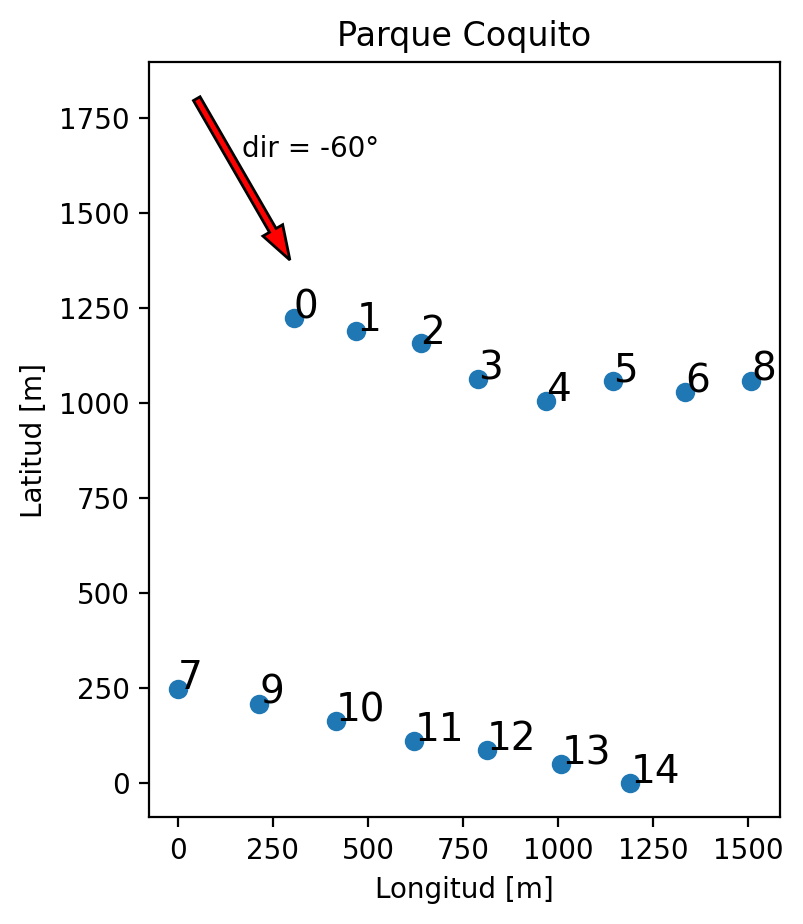

In [14]:
pintar_turbinas_ordenadas(-60)
ax = plt.gca()
x = 50
y = 1800
dx = 400*cos(radians(-60))
dy = 400*sin(radians(-60))
ax.arrow(x,y,dx,dy, width=20, fc='red')
ax.text(x+dx/2+ 20,y+dy/2+20, 'dir = -60°')



### Modelo de estela de Jensen y de Koch

Estos dos modelos se basan en un crecimiento de estela lineal supeditado por la constante $k_w$. El modelo de Koch tiene en cuenta la proporción de área afectada por la estela sobre cada rotor, factor que se denota $\beta$, y que se tiene en cuenta al realizar la sumatoria de estelas.

In [36]:

kw = 0.075 #k_wake, despues nos complicamos
diam_turbinas = 92
D = 92

def turbinas_afectadas_Jensen(n_tur,direccion, kw = kw):
    '''
    Retorna 
        [0]: una lista booleana de las turbinas que se ven afectadas por la estela de la turbina #n_tur, con dirección de viento direccion
        [1]: una lista con las distancias paralelas a direccion entre las turbinas. Si la turbina no se ve afectada por la estela retorna 0
    '''
    
    x0 = long_turbinas_m[n_tur]
    y0 = lat_turbinas_m[n_tur]
    D = diam_turbinas

    x = np.array(long_turbinas_m) - x0
    y = np.array(lat_turbinas_m) - y0
    ##definir area incidente
    phi = radians(direccion)
    gamma = np.arctan2(y,x)
    r = sqrt(x**2+y**2)
    omega = phi - gamma
    xbar = r*sin(omega)
    ybar = r*cos(omega)


    turbinas_afectadas = (xbar<D/2+kw*ybar) & (xbar>-D/2-kw*ybar) & (ybar>0)
            

    return turbinas_afectadas, ybar*turbinas_afectadas


def calcular_areas_incidentes(r_w, D, xbar):
    """
        Calcula la proporcion (beta) de area de la estela incidente sobre el area del rotor afectado
        referencia https://diego.assencio.com/?index=8d6ca3d82151bad815f78addf9b5c1c6
            
            r_w = radio de la estela
            D = diametro del rotor afectado
            xbar = distancia perpendicular entre centroide estela y centro del rotor aguasabajo
            
            Retorna: beta = 0 si estela no afecta, 1 si la estela encierra completamente al rotor, de 0 a 1 caso contrario
    """
    r1 = r_w
    r2 = D/2
    d = np.abs(xbar)
    # if((d >= r1 + r2) | ((d == 0) & (r1+r2 == D))): beta = 0
    if(d >= r1 + r2): beta = 0
    elif(d <= r1-r2): beta = 1
    else:
        d1 = (r1**2 - r2**2 + d**2)/(2*d)
        d2 = d-d1
        from numpy import arccos
        beta = (r1**2*arccos(d1/r1) - d1*sqrt(r1**2 - d1**2) + r2**2*arccos(d2/r2) - d2*sqrt(r2**2 - d2**2))/(np.pi*D**2/4)
    return beta

def turbinas_afectadas_Koch(n_tur, direccion, kw=kw):
    """
        Calcula las turbinas afectadas por la estela de Koch, teniendo en cuenta el factor \beta
        Argumentos:
            n_tur: número de la turbina cuya estela se va a calcular
            direccion: dirección del viento incidente, en grados
        Retorna:
            [0] turbinas_afectadas: lista binaria con las turbinas que caen dentro de la estela (1) y las que no (0)
            [1] dist_ybar: distancia perpendicular desde la turbina de entrada hasta la turbina en barlovento. 0 si la
            turbina no se ve afectada por la estela
            [2] vector de proporciones beta
    
    """

    x0 = long_turbinas_m[n_tur]
    y0 = lat_turbinas_m[n_tur]
    D = diam_turbinas

    x = np.array(long_turbinas_m) - x0
    y = np.array(lat_turbinas_m) - y0
    r = sqrt(x**2+y**2)
    omega = np.arctan2(y,x) - radians(direccion)
    xbar = r*sin(omega)
    ybar = r*cos(omega)

    r_w =  D/2 + kw*np.abs(xbar) #radius of wake
    turbinas_afectadas = (ybar>0) & (np.abs(xbar)< r_w + D/2)
    dist_ybar = turbinas_afectadas*ybar
    beta = np.vectorize(calcular_areas_incidentes, otypes = [np.float64])(r_w, D, xbar)

    return turbinas_afectadas, dist_ybar,beta


def estela_Jensen(U,dir, kw = kw):
    l = ordenar_turbinas(dir)
    n_tur = len(l)
    def_vel = np.ones([n_tur,n_tur]) #deficit velocidad
    vel = np.zeros(len(l))
    for idx,t in enumerate(l):
        
        vel[t] = U*(1-np.sqrt(np.sum((1-def_vel[t])**2)))
        v = vel[t]
        Ct = calcular_Ct(v)
        ybar_t = turbinas_afectadas_Jensen(t,dir)[1]
        def_vel_t = np.where(ybar_t ==0, 1, 1-(1-np.sqrt(1-Ct))/(1+2*kw*ybar_t/diam_turbinas)**2)

        for i in range(0,n_tur-1):
            def_vel[i][t] = def_vel_t[i]

    return vel



def estela_Jensen_singular(U,dir, x,y, par, kw = 0.075):
    
    Ct = calcular_Ct(U)
    if par=='Jepirachi': D = 60 #Jepirachi
    elif par=='Coquito': D = 92 #Coquito
    else: raise Exception("Parque invalido")
    r = sqrt(x**2+y**2)
    omega = np.arctan2(y,x) - radians(dir)
    xbar = r*sin(omega)
    ybar = r*cos(omega)

    r_w =  D/2 + kw*np.abs(ybar) #radius of wake
    if ((ybar>0) & (np.abs(xbar)< r_w)):
        def_vel = (1-np.sqrt(1-Ct))/(1+2*kw*ybar/D)**2
    else: def_vel = 0
    return def_vel

def estela_Koch(U,dir, kw = 0.075):
    """
    Calcula el efecto de la estela de Koch para el parque eólico
    """

    l = ordenar_turbinas(dir)
    n_tur = len(l)
    def_vel = np.zeros([n_tur,n_tur]) #deficit velocidad
    beta_mat = np.zeros([n_tur,n_tur]) 
    vel = np.zeros(len(l))
    for idx,t in enumerate(l):
        
        vel[t] = U*(1-np.sqrt(np.sum(beta_mat[t]*(def_vel[t])**2)))
        v = vel[t]
        Ct = calcular_Ct(v)
        estela = turbinas_afectadas_Koch(t,dir, kw=kw)
        ybar_t = estela[1]
        beta_ = estela[2] 
        def_vel_t = np.where(ybar_t ==0, 0, (1-np.sqrt(1-Ct))/(1+2*kw*ybar_t/diam_turbinas)**2)

        for i in range(0,n_tur-1):
            def_vel[i][t] = def_vel_t[i]
            beta_mat[i][t] = beta_[i]

    return vel


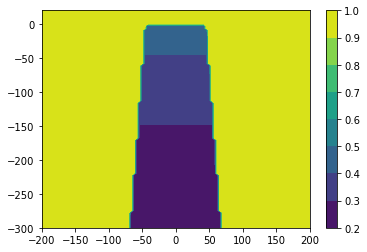

In [87]:
xran = np.linspace(-200,200,100)
yran = np.linspace(20,-300,100)
mat_Koch = np.zeros([len(yran),len(xran)])
for i,x in enumerate(xran):
    for j,y in enumerate(yran):
        mat_Koch[j,i] = estela_Jensen_singular(10,-90,x,y,'Coquito')


plt.contourf(xran,yran,mat_Koch)
plt.colorbar()

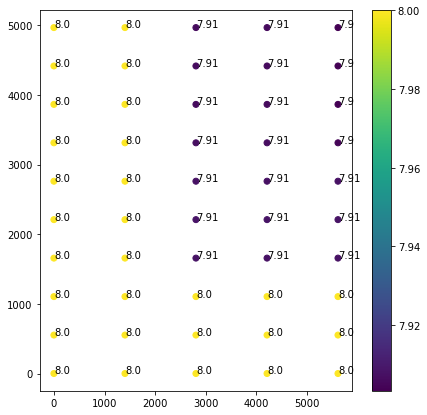

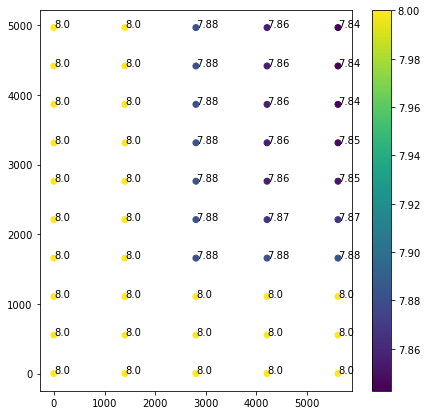

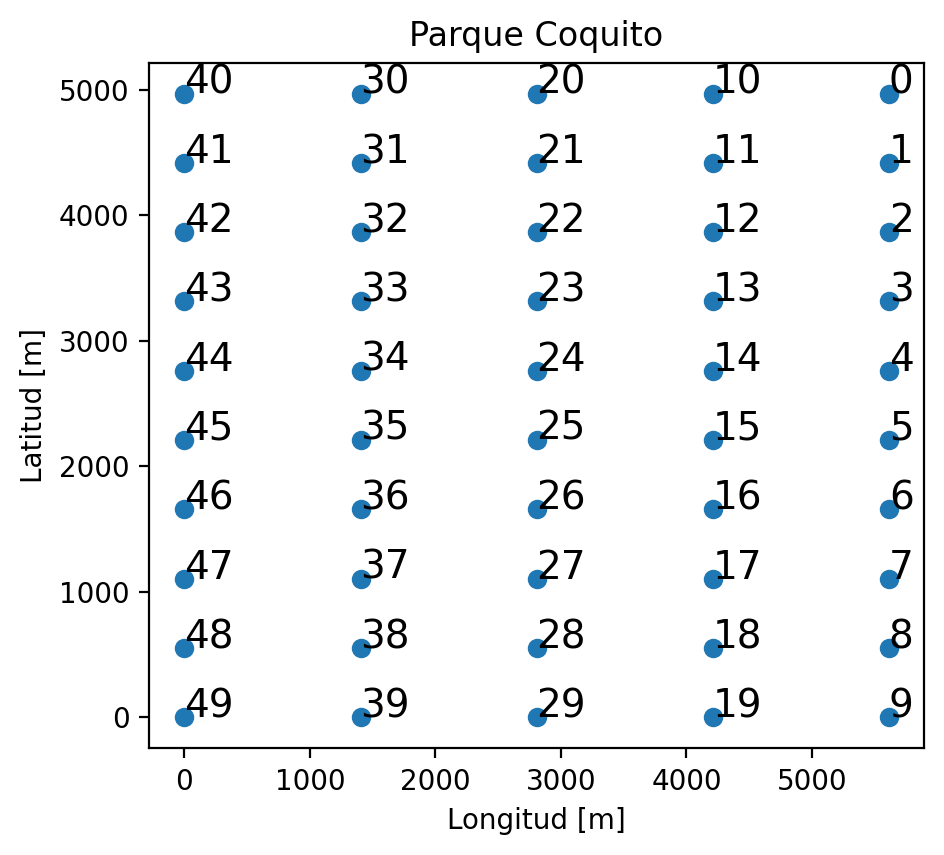

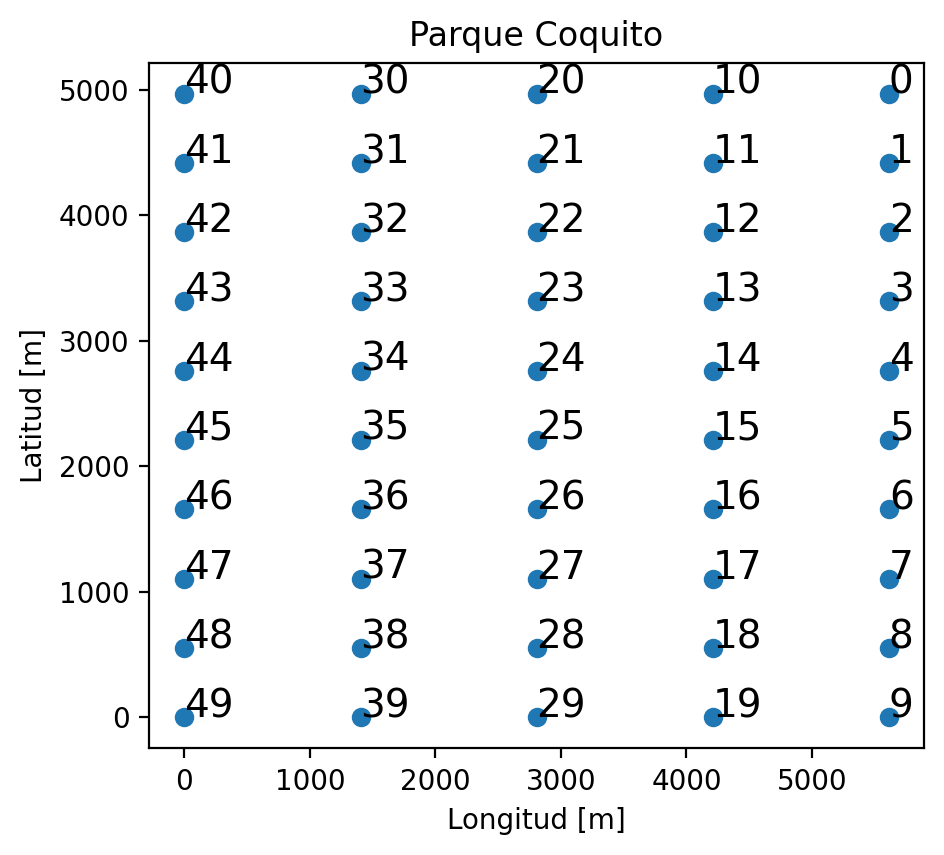

In [65]:

pintar_velocidades_parque(estela_Koch(8,30))
pintar_velocidades_parque(estela_Jensen(8,30))
pintar_turbinas_ordenadas(0, True)
cargar_datos_Coquito()
pintar_turbinas_ordenadas(0, True)
# turbinas_afectadas_Koch(14, 30)
# pintar_estela_turbina(14,30)

Se agrega la siguiente función para visualizar la estela que genera una turbina

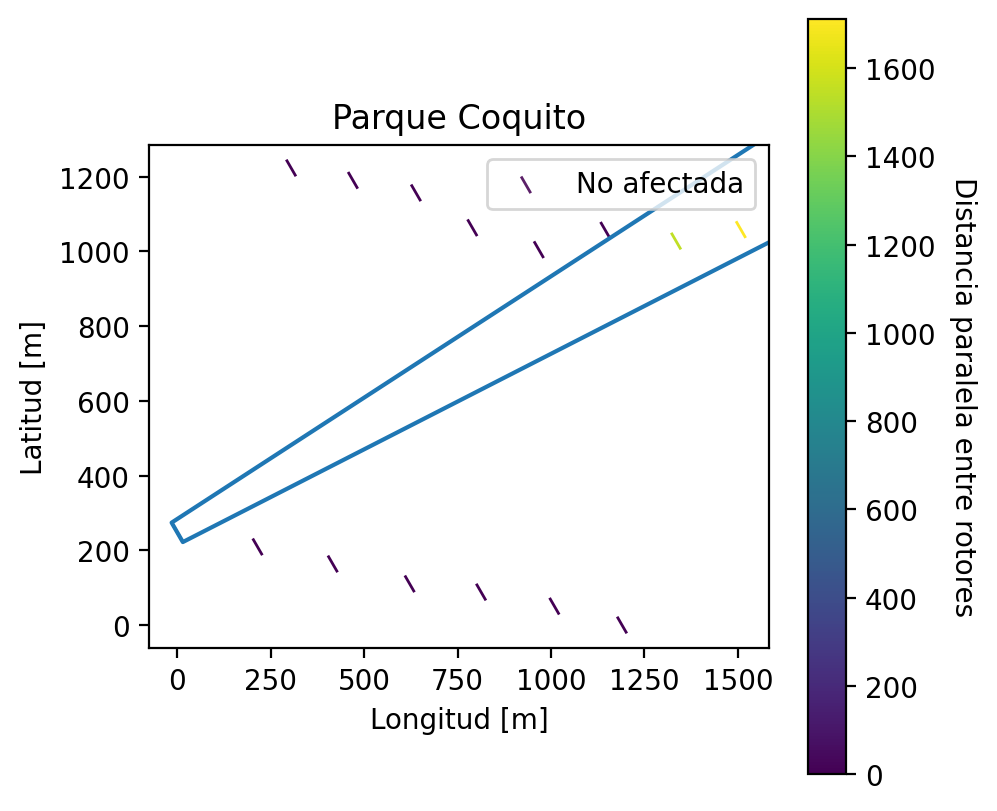

In [9]:
def pintar_estela_turbina(turbina,direccion, hold = False):
    D = diam_turbinas
    
    if hold == False:
        plt.figure(figsize=(5, 5), dpi=200)
    
    alpha = np.radians(direccion) - np.pi/2
    x1 = - D/2*np.cos(alpha) 
    y1 = D/2*np.sin(alpha)
    x2 = D/2*np.cos(alpha)
    y2 = - D/2*np.sin(alpha)
    verts = list(zip([x1,x2],[y2,y1]))

    plt.scatter(long_turbinas_m,lat_turbinas_m,c=turbinas_afectadas_Koch(turbina,direccion)[1], marker=verts)

    # plt.scatter(long_torres_m,lat_torres_m)
    plt.title('Parque Coquito')
    plt.xlabel('Longitud [m]')
    plt.ylabel('Latitud [m]')
    cbar = plt.colorbar()
    cbar.set_label('Distancia paralela entre rotores', labelpad = 15,rotation=270)
    ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.set_aspect('equal')
    ax.legend(['No afectada'])
    leg = ax.get_legend()
    leg.legendHandles[0].set_color('#5b2068')
   

    x0 = long_turbinas_m[turbina]
    y0 = lat_turbinas_m[turbina]

    alpha = np.radians(direccion) - np.pi/2


    x1 = x0 - D/2*np.cos(alpha)
    y1 = y0 + D/2*np.sin(alpha)
    x2 = x0 + D/2*np.cos(alpha)
    y2 = y0 - D/2*np.sin(alpha)

    R = sqrt(2)/2*(max(long_turbinas_m)+max(lat_turbinas_m))
    beta = np.pi/2 - np.arctan(kw) - np.radians(direccion)
    x3 = x1 + R*np.sin(beta)
    y3 = y1 + R*np.cos(beta)
    x4 = x2 + R*np.cos(np.radians(direccion)-np.arctan(kw))
    y4 = y2 + R*np.sin(np.radians(direccion)-np.arctan(kw))

    plt.plot([x3,x1,x2,x4],[y3,y2,y1,y4])
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

pintar_estela_turbina(14, 30)

Una vez implementados estos modelos, se puede predecir la producción de energía en un parque.

Estimación Jepirachi:

In [19]:
def find_nearest(array, value): 
    array = np.asarray(array);     
    idx = (np.abs(array - value)).argmin();     
    return idx


def kWh(v):
    return np.sum([Pot[find_nearest(Vels,v[i])] for i in range(len(v))])/6


cargar_datos_Jepirachi()


fechas = datos_torre['Fecha']
idx = fechas.isin(pots['Fecha'])

vels_parque = datos_torre['Velocidad'][idx]
vels_parque.reset_index(drop=True, inplace=True)
dir_parque = datos_torre['Direccion'][idx]
dir_parque.reset_index(drop=True, inplace=True)


E_Jensen = 0
E_Koch = 0


rango = len(vels_parque)
# rango = 50 #test
for i in range(rango):
    E_Jensen+=kWh(estela_Jensen(vels_parque[i],dir_parque[i]))
    E_Koch+=kWh(estela_Koch(vels_parque[i],dir_parque[i]))


pots_ = pots.drop(columns = ['Fecha'])
E_data = pots_.sum().sum()/6


print(E_Jensen)
print(E_Koch)
print(E_data)
print('El error en la predicción es de', (E_Jensen-E_data)/E_data*100, '%')

16475246.41666667
16471641.150000008
6169763.810325802
El error en la predicción es de 167.03204406453077 %


Como se puede ver, la predicción para el parque Jepirachi es relativamente mala. Se cree que esto puede ser dado el hecho que no se poseen datos de $C_T$ para las turbinas Nordex N60 que posee este parque, sino que se utilizaron los datos de las turbinas del parque Coquito.

La sobreestimación es de alrededor de un factor de 3. 

Estimación Coquito

In [66]:
def find_nearest(array, value): 
    array = np.asarray(array);     
    idx = (np.abs(array - value)).argmin();     
    return idx

def kWh(v):
    return np.sum([Pot[find_nearest(Vels,v[i])] for i in range(len(v))])

##datos coquito
cargar_datos_Coquito()


viento_Coquito = pd.read_csv('datos_met_F.csv',skiprows=[0],decimal=',') #Torre 1

vels_parque = viento_Coquito[['wSpeed_98']].values
dir_parque = viento_Coquito[['wDir_98']].values

E_Jensen = 0
E_Koch = 0
for i in range(len(vels_parque)):
# for i in range(10):
    E_Jensen+=kWh(estela_Jensen(vels_parque[i],dir_parque[i]))
    E_Koch+=kWh(estela_Koch(vels_parque[i],dir_parque[i]))



E_Jensen = E_Jensen/10000000 #GWh/año
E_Koch = E_Koch/10000000 #GWh/año
print(E_Jensen)
print(E_Koch)
E_data = 380.0 # GWh/año
print('El error en la predicción es de', (E_Jensen-E_data)/E_data*100, '%')

391.40264054000073
418.1047556000006
El error en la predicción es de 3.000694878947561 %


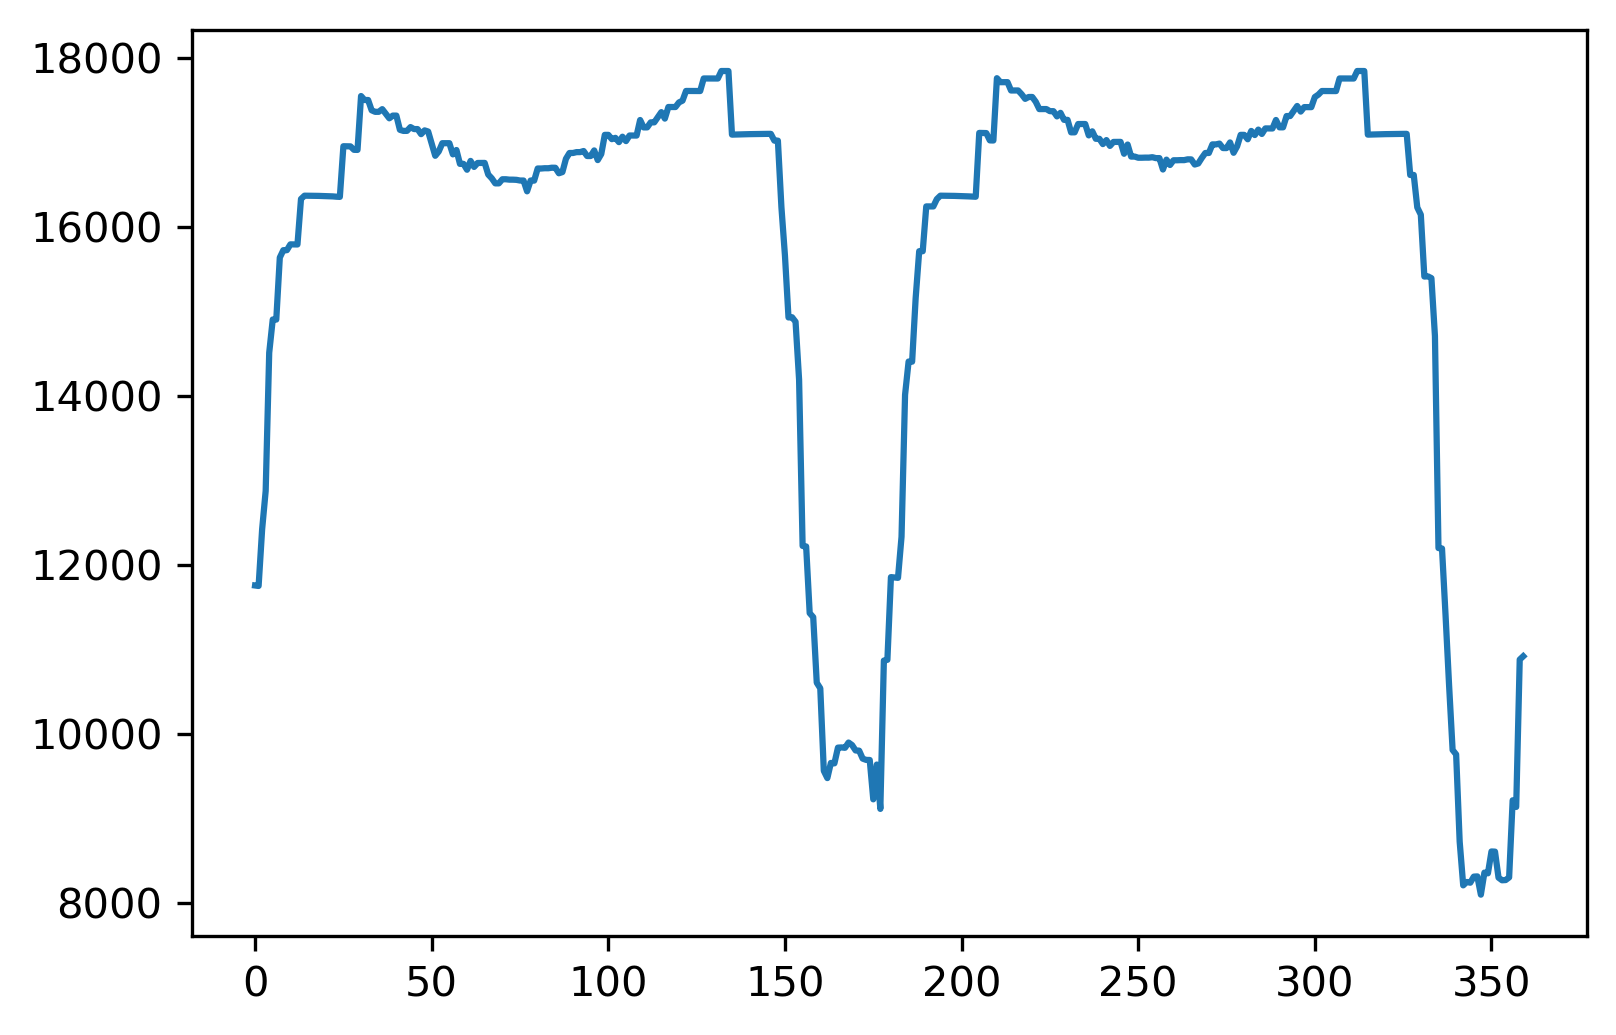

In [81]:
cargar_datos_Jepirachi()
angles = np.arange(0,360,1)
U = 8.5
P = np.zeros(len(angles))
for idx,ang in enumerate(angles):
    P[idx] = np.sum([interp_pot(v) for v in estela_Jensen(U,ang)])

plt.plot(angles,P)

In [63]:
def find_nearest(array, value): 
    array = np.asarray(array);     
    idx = (np.abs(array - value)).argmin();     
    return idx

def kWh(v):
    return np.sum([Pot[find_nearest(Vels,v[i])] for i in range(len(v))])

##datos coquito
cargar_datos_Coquito()


viento_Coquito = pd.read_csv('datos_met_F.csv',skiprows=[0],decimal=',') #Torre 1

vels_parque = np.reshape(viento_Coquito[['wSpeed_98']].values, (-1,))
dir_parque = viento_Coquito[['wDir_98']].values

vels_cnt = pd.cut(vels_parque, np.arange(0, 31, 1)).value_counts()
vels_cnt.index = np.arange(0.5, 30.5, 1)

dir_cnt = pd.cut(dirs_parque, np.arange(0, 360, 5)).value_counts()
df_cnt.index
for val,cnt in vels_cnt.iteritems():
    print(val, cnt)

E_Jensen = 0
E_Koch = 0
E_Howland = 0
# for i in range(len(vels_parque)):
# # for i in range(10):
#     E_Jensen+=kWh(estela_Jensen(vels_parque[i],dir_parque[i]))
#     E_Koch+=kWh(estela_Koch(vels_parque[i],dir_parque[i]))
#     E_Howland+=kWh(estela_Howland(vels_parque[i],dir_parque[i],D=92))



# E_Jensen = E_Jensen/10000000 #GWh/año
# E_Koch = E_Koch/10000000 #GWh/año
# E_Howland = E_Howland/10000000 #GWh/año
# print(E_Jensen)
# print(E_Koch)
# print(E_Howland)
# E_data = 360.0 # GWh/año
# print('El error en la predicción es de', (E_Jensen-E_data)/E_data*100, '%')
# print('Para el modelo de Howland es de', (E_Howland-E_data)/E_data*100, '%')


1 506
2 1328
3 2154
4 2958
5 4436
6 7801
7 12490
8 17946
9 18613
10 12987
11 5244
12 1085
13 78
14 1
15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0


Para el parque Coquito, donde los datos de $C_T$ sí corresponden a los de la turbina, podemos ver que la estimación es mucho más cercana a la real, que es de 360 MWh/año, como se muestra en el Anexo 1 de la resolución CREG 1127 del 2017. El error para los cálculos en este caso es del 7% utilizando el modelo de Koch, donde los presentes muestran una sobreestimación. Esto se cree que se debe debido a la falta de implementación de otras perdidas del acuerdo, como pérdidas por cableado, o modificaciones de entrega de potencia por densidad del viento. A pesar de que estas pérdidas se consideran importantes, se salen del alcance del trabajo actual.

Modelo Bastankhah (2016)

Cuadrar parámetros $k_y$ y $k_z $ según datos históricos de viento y Potencia.

Modelo no funciona aún

In [21]:
cargar_datos_Jepirachi()
altura_cubo = 60 #?


def Modelo_Bastankhah(U, yaw, x,y,z, k_y = 0.1, k_z = 0.1):

    """
    Bastankhah et al. - Experimental and theoretical study of wind turbine wakes in yawed conditions (2016)
    """

    ## definicion de constantes del problema
    ######## = revisar
    # d = diam_turbinas[0] ##revisar si es necesario convertir al algoritmo dependiente del numero de turbina
    d = diam_turbinas
    z_h = altura_cubo
    alph = 2.32
    beta = 0.154
    # k_y = 1 ########################
    # k_z = k_y
    I = 0.06 # 6% ############


    yaw = radians(yaw)
    Ct = calcular_Ct(U)
    x_0 = 1/sqrt(2)*d*cos(yaw)*(1+sqrt(1-Ct))/(alph*I + beta*(1-sqrt(1-Ct)))
    sigma_y = k_y*(x-x_0) + d*cos(yaw)/sqrt(8)
    sigma_z = k_z*(x-x_0) + d/sqrt(8)
    theta_ = 0.3*yaw/cos(yaw)*(1-sqrt(1-Ct*cos(yaw)))
    #revisar como ordenar condicional
    #x <= x_0, close wake
    delta_close = theta_*x
    delta_far = theta_*(x_0 + d/14.7*sqrt(cos(yaw)/(k_y*k_z*Ct))*(2.9 + 1.3*sqrt(1-Ct) - Ct)*
        log((1.6+sqrt(Ct))*(1.6*sqrt(8*sigma_y*sigma_z/(d**2*cos(yaw)))-sqrt(Ct))/((1.6-sqrt(Ct))*(1.6*sqrt(8*sigma_y*sigma_z/(d**2*cos(yaw)))+sqrt(Ct)))))
    delta_inft = theta_*(x_0 + d/14.7*sqrt(cos(yaw)/(k_y*k_z*Ct))*(2.9 + 1.3*sqrt(1-Ct) - Ct)*
        log((1.6+sqrt(Ct))/(1.6-sqrt(Ct))))
    delta = delta_far if x>x_0 else delta_close
    def_vel_ = (1-sqrt(1- Ct*cos(yaw)/(8*sigma_y*sigma_z/(d**2))))*exp(-0.5*((y-delta)/sigma_y)**2)*exp(-0.5*((z-z_h)/sigma_z)**2)

    ## x<x_0
    delta_0 = theta_*x_0
    u_r = U*Ct*cos(yaw)/(2*(1-sqrt(1-Ct*cos(yaw))))
    m1 = theta_ - d/(2*x_0)*sqrt(u_r/U)
    m2 = theta_ + d/(2*x_0)*sqrt(u_r/U)
    b1 =  d/(2*x_0)*sqrt(u_r/U)
    b2 = -d/(2*x_0)*sqrt(u_r/U)
    
    if(x<0):
        vel = U
        def_vel_ = 0
    elif (x<x_0):
        y1 = m1*x + b1
        y2 = m2*x + b2
        u_0 = U*(1-Ct)
        if (y < y1 and y > y2):
            vel = u_0
        else: vel = U
        def_vel_ = U-vel
    else:
        vel = U*(1-def_vel_)
    return vel, def_vel_




def Modelo_Bastankhah_inv(U, dir, turb_incidente, yaw, turb_afectada, k_y = 0.1, k_z= 0.1):
    """
    Calcula la velocidad inducida por una turbina sobre otra
    retorna la velocidad puntual en la nacelle de la turbina afectada
    Asume que no hay turbinas adicionales entre la incidente y la afectada (estelas afectarian el resultado)
        turb_incidente: numero de la turbina incidente segun la lista (int)
        turb_afectada: numero de la turbina afectada segun la lista (int)
    """
    n0 = turb_incidente
    n1 = turb_afectada
    x0 = long_turbinas_m[n0]
    y0 = lat_turbinas_m[n0]
    x1 = long_turbinas_m[n1]
    y1 = lat_turbinas_m[n1]

    
    xrel = x1 - x0
    yrel = y1 - y0
    r = np.sqrt(xrel**2 + yrel**2)
    omega = radians(dir) - np.arctan2(yrel,xrel)
    y = r*np.sin(omega)
    x = r*np.cos(omega)
    
    z_h = altura_cubo
    return Modelo_Bastankhah(U,yaw,x,y,z_h, k_y, k_z)[0]


k_y = 0.1
k_z = 0.1
alph = 2.32
beta = 0.154
I = 0.06 # 6% ############
d = 60 #revisar si es necesario convertir al algoritmo dependiente del numero de turbina

yaw = radians(0)
Ct = calcular_Ct(10)
x_0 = 1/sqrt(2)*d*cos(yaw)*(1+sqrt(1-Ct))/(alph*I + beta*(1-sqrt(1-Ct)))
x = 450
sigma_y = k_y*(x-x_0) + d*cos(yaw)/sqrt(8)
sigma_z = k_z*(x-x_0) + d/sqrt(8)
log1 = log((1.6+sqrt(Ct))*(1.6*sqrt(8*sigma_y*sigma_z/(d**2*cos(yaw)))-sqrt(Ct))/((1.6-sqrt(Ct))*(1.6*sqrt(8*sigma_y*sigma_z/(d**2*cos(yaw)))+sqrt(Ct))))
log2 = log((1.6+sqrt(Ct))*(1.6*sqrt(8*sigma_y*sigma_z/(d**2*cos(yaw)))-sqrt(Ct))/((1.6-sqrt(Ct))*(1.6*sqrt(8*sigma_y*sigma_z/(d**2*cos(yaw)))+sqrt(Ct))))
print(x_0)
print(sigma_y)
print(log1)

310.43041632205194
35.17016180339123
0.5129029662622355


0.4614835192865495
299.1487587327532
-50.42796000081978


C:\Users\user\AppData\Local\Temp/ipykernel_7712/225432728.py:37: RuntimeWarning: invalid value encountered in sqrt
  def_vel_ = (1-sqrt(1- Ct*cos(yaw)/(8*sigma_y*sigma_z/(d**2))))*exp(-0.5*((y-delta)/sigma_y)**2)*exp(-0.5*((z-z_h)/sigma_z)**2)


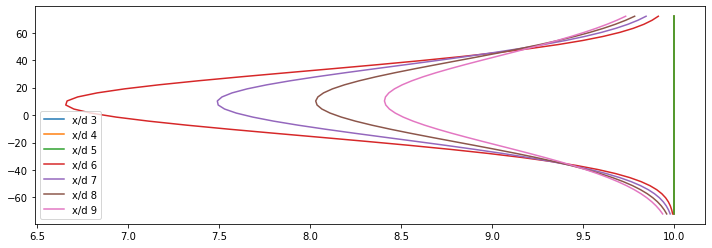

In [22]:

U = 10
yaw = 10
z_h = altura_cubo
d = diam_turbinas#[0] #Coquito
d = diam_turbinas

xrange = d*np.arange(3,10)
Ct = calcular_Ct(U)
alph = 2.32
beta = 0.164
I = 0.06
print((1-sqrt(1-Ct)))
yaw = radians(yaw)
x_0 = 1/sqrt(2)*d*cos(yaw)*(1+sqrt(1-Ct))/(alph*I + beta*(1-sqrt(1-Ct)))
print(x_0)
print(lat_turbinas_m[8] - lat_turbinas_m[9])
ky = np.linspace(0.001, 1, 10)
x_grid, ky_grid = np.meshgrid(xrange, ky)
sigma_y = ky_grid*(x_grid-x_0) + d*cos(yaw)/sqrt(8)
sigma_z = (xrange-x_0) + d/sqrt(8)
# print(sigma_y)
yrange = np.linspace(-1.2,1.2)*d
mat = np.zeros((len(xrange),len(yrange)))
def_vel_mat = np.zeros((len(xrange),len(yrange)))
k = 0.05
for i,x in enumerate(xrange):
    for j,y in enumerate(yrange):
        mat[i,j] = Modelo_Bastankhah(U,np.degrees(yaw),x,y,z_h, k_y=k, k_z = k)[0]
        def_vel_mat[i,j] = Modelo_Bastankhah(U,np.degrees(yaw),x,y,z_h, k_y=k, k_z = k)[1]
    # plt.plot(xrange/d,sigma_y[:][i])
# print(Modelo_Bastankhah(U,yaw, 5*d, 0, z_h ))
# print(mat[6])


fig, ax = plt.subplots(figsize = (12,4))

scale = np.max(mat[0])-np.min(mat[0])

for i,x in enumerate(xrange):
    plt.plot(mat[i], yrange, label="x/d {:g}".format(x/d))
    plt.legend()
    if i==0:
        pos = x
        # print(mat[i]-np.min(mat[i]))
        # ax.plot(x/d + (mat[i]-np.min(mat[i]))/scale, yrange)



#### Modelo Bastankhah en granja. 
Suposición 1) Potencia depende de velocidad en la nacelle (promedio sobre área de rotor por implementar). Suposición 2) Superposición de deficits por energía cinética (no lineal) dado por $u(x,y) = u_\infty - \sqrt{\sum_{i}^{N_f} {\Delta u_i}^2}$

In [23]:

k_y = 1
k_z = 1

x = k_y, k_z

k = 0.1

print(Modelo_Bastankhah_inv(10, 90, 49, 0, 48, k, k))

def windfarm_Bastankhah(U, dir, yaw_vec, k_y = k, k_z=k):
    """
    calcula las velocidades de cada turbina utilizando el modelo de bastankhah
    """
    yaw_vec = np.array(yaw_vec)
    # print(yaw_vec[10])
    l = ordenar_turbinas(dir)
    n_tur = len(l)
    vel = np.zeros(len(l))
    def_vel = np.zeros([n_tur,n_tur]) #deficit velocidad
    for idx,t in enumerate(l):
        vel[t] = U*(1-np.sqrt(np.sum((def_vel[t])**2)))
        # if idx==1: print(def_vel)
        for i in range(idx+1,n_tur):
            vel_i = Modelo_Bastankhah_inv(U,dir,t,yaw_vec[t],l[i], k_y, k_z)
            print(t, l[i])
            print(vel_i)
            def_vel[t][l[i]] = 1 - vel_i/U
            
    return vel


windfarm_Bastankhah(10,90, [0]*50)


def pot_Bastankhah(x):

    k_y = x[0]
    k_z = x[1]
    
    w_speed = vels_parque.reshape((-1,))
    w_dir = dir_parque.reshape((-1,))

    
    E = 0
    E2 = 0
    for i in range(1):
        E+=kWh(windfarm_Bastankhah(w_speed[i],w_dir[i], [0]*50, k_y, k_z))
        E2+=kWh([w_speed[i]]*50)
    return E

print(type([0.01,0.01]))

k = np.logspace(-3.0, 2.0, num= 15)
pots = np.zeros(len(k))
for i,ki in enumerate(k):
    # print(type(ki))
    pots[i] = pot_Bastankhah([ki,ki])

print(pots)

IndexError: list index out of range

In [ ]:
# !pip install --upgrade pandas
dir = 90
l = ordenar_turbinas(dir)
# for idx,t in enumerate(l):
    # print(idx,t)
    # print(l[idx])
U =10
dir = 90
yaw_vec = [0]*50
yaw_vec = np.array(yaw_vec)
l = ordenar_turbinas(dir)
n_tur = len(l)
vel = np.zeros(len(l))
def_vel = np.zeros([n_tur,n_tur]) #deficit velocidad
for idx,t in enumerate(l):
    vel[t] = U*(1-np.sqrt(np.sum((def_vel[t])**2)))
    # print(t)
    if(t == 48): print(vel[48])
    # if idx==1: print(def_vel)
    for i in range(idx+1,n_tur):
        vel_i = Modelo_Bastankhah_inv(U,dir,t,yaw_vec[t],l[i])
        # print(vel_i)
        def_vel[l[i]][t] = 1 - vel_i/U
        if(t==48): print(def_vel[48])


# print(Modelo_Bastankhah(U, 0, 551, 0, altura_cubo))
n0 = 49
n1 = 48
x0 = long_turbinas_m[n0]
y0 = lat_turbinas_m[n0]
x1 = long_turbinas_m[n1]
y1 = lat_turbinas_m[n1]


xrel = x1 - x0
yrel = y1 - y0
r = np.sqrt(xrel**2 + yrel**2)
omega = radians(dir) - np.arctan2(yrel,xrel)
x = r*np.sin(omega)
y = r*np.cos(omega)

# z_h = altura_cubo
# print(Modelo_Bastankhah(10,0,lat_turbinas_m[48]-lat_turbinas_m[49],0,z_h,0.1,0.1))
# print(Modelo_Bastankhah_inv(U, 90, 49, 0, 48, 0.1, 0.1))
# print(U*(1-np.sqrt(np.sum((def_vel[49])**2))))
# k = 0.001
# print(Modelo_Bastankhah_inv(U,dir,9,0,0, k_y = k, k_z = k))
# pintar_turbinas_ordenadas(90, idx = True)

print(def_vel[48])
print(vel[48])
print((1-np.sqrt(np.sum((def_vel[48])**2))))
print(vel)
# plt.figure(figsize=(20, 20), dpi=200)
# for i,t in enumerate(vel):
    # print(vel[t])
pintar_velocidades_parque(vel, 10)

x1 = lat_turbinas_m[8]- lat_turbinas_m[9]
U = 10
v = Modelo_Bastankhah(U, 0, x1, 0,0)[0]
w = Modelo_Bastankhah_inv(U, 90, 9, 0, 8)
n0 = 9
n1 = 8
x0 = long_turbinas_m[n0]
y0 = lat_turbinas_m[n0]
x1 = long_turbinas_m[n1]
y1 = lat_turbinas_m[n1]


xrel = x1 - x0
yrel = y1 - y0
r = np.sqrt(xrel**2 + yrel**2)
omega = radians(dir) - np.arctan2(yrel,xrel)
y = r*np.sin(omega)
x = r*np.cos(omega)

z_h = altura_cubo
w2 = Modelo_Bastankhah(U,yaw,x,y,z_h)[0]
print(v)
print(w)
print(w2)
print(Modelo_Bastankhah(v, 0, x1, 0,0))
print(Modelo_Bastankhah(U, 0, 2*x1, 0,0))


C:\Users\user\AppData\Local\Temp/ipykernel_59472/225432728.py:33: RuntimeWarning: invalid value encountered in log
  log((1.6+sqrt(Ct))*(1.6*sqrt(8*sigma_y*sigma_z/(d**2*cos(yaw)))-sqrt(Ct))/((1.6-sqrt(Ct))*(1.6*sqrt(8*sigma_y*sigma_z/(d**2*cos(yaw)))+sqrt(Ct)))))
C:\Users\user\AppData\Local\Temp/ipykernel_59472/225432728.py:37: RuntimeWarning: invalid value encountered in sqrt
  def_vel_ = (1-sqrt(1- Ct*cos(yaw)/(8*sigma_y*sigma_z/(d**2))))*exp(-0.5*((y-delta)/sigma_y)**2)*exp(-0.5*((z-z_h)/sigma_z)**2)


IndexError: list index out of range

#### Modelo de Howland/Shapiro

In [42]:
from math import erf
from scipy import integrate


"""
Definicion de constantes
"""
k_w = 0.0834
D = 60
sigma_0 = 0.235*D



def integrate_centerline(x0, x):
    integrand = lambda x: 1/2*(1/4*Ct*U*cos(yaw)**2*sin(yaw))*(1+erf(x/(d/2*sqrt(2))))/(1+k_w*log(1+exp(2*(x/D-1))))**2
    return integrate.quad(integrand, x0, x)


def Modelo_Howland(U, yaw, x, y, D, sigma_0 = sigma_0, k_w = k_w):
    """
    Modelo basado en lifting line modelling (Shapiro et al 2018)
    """
    yaw = radians(yaw)
    

    Ct = calcular_Ct(U)
    delta_u_0 = U*(1-sqrt(1-Ct*cos(yaw)**2))
    dw = 1 + k_w * log(1 + exp(2*(x/D + 1)))
    delta_u_i = delta_u_0/dw**2 * 1/2 *(1 + erf(x/(D/2*sqrt(2))))

    sigma_0_i = sigma_0
    x0 = 0
    integrand = lambda x: 1/2*(1/4*Ct*cos(yaw)**2*sin(yaw))*(1+erf(x/(D/2*sqrt(2))))/(1+k_w*log(1+exp(2*(x/D-1))))**2
    y_c_i = integrate.quad(integrand, x0, x)[0]
    u = U - delta_u_i*D**2/(8*sigma_0_i**2)*exp(-(y - y_c_i)**2/(2*sigma_0_i**2*dw**2))
    return u


def Modelo_Howland_avg_rotor(U, yaw, x, y, sigma_0 = sigma_0, k_w = k_w):
    """
    Modelo basado en lifting line modelling (Shapiro et al 2018)
    """

    yaw = radians(yaw)
    

    Ct = calcular_Ct(U)
    delta_u_0 = U*(1-sqrt(1-Ct*cos(yaw)**2))
    dw = 1 + k_w * log(1 + exp(2*(x/D + 1)))
    delta_u_i = delta_u_0/dw**2 * 1/2 *(1 + erf(x/(D/2*sqrt(2))))

    sigma_0_i = sigma_0
    x0 = 0 # 0 vs -inf ?, 0 is accurate
    integrand = lambda x: 1/2*(1/4*Ct*cos(yaw)**2*sin(yaw))*(1+erf(x/(d/2*sqrt(2))))/(1+k_w*log(1+exp(2*(x/D-1))))**2
    y_c_i = integrate.quad(integrand, x0, x)[0]
    u = U - delta_u_i*D**2/(8*sigma_0_i**2)*exp(-(y - y_c_i)**2/(2*sigma_0_i**2*dw**2))
    return u


def Modelo_Howland_inv(turb_incidente, turb_afectada, U, dir, yaw, D, sigma_0 = sigma_0, k_w = k_w):

    n0 = turb_incidente
    n1 = turb_afectada
    x0 = long_turbinas_m[n0]
    y0 = lat_turbinas_m[n0]
    x1 = long_turbinas_m[n1]
    y1 = lat_turbinas_m[n1]

    
    xrel = x1 - x0
    yrel = y1 - y0
    r = np.sqrt(xrel**2 + yrel**2)
    omega = radians(dir) - np.arctan2(yrel,xrel)
    y = r*np.sin(omega)
    x = r*np.cos(omega)
    
    return Modelo_Howland(U,yaw,x,y, D, sigma_0, k_w)



def estela_Howland(U, dir, D, sigma_0 = sigma_0, k_w = k_w, yaw_vec = [0]*len(lat_turbinas_m)):
    
    yaw_vec = np.array(yaw_vec)
    l = ordenar_turbinas(dir)
    n_tur = len(l)
    vel = np.zeros(len(l))
    def_vel = np.zeros([n_tur,n_tur]) #deficit velocidad
    for idx,t in enumerate(l):
        vel[t] = U*(1-np.sqrt(np.sum((def_vel[t])**2)))
        v = vel[t]
        # print("Turbina # ",t,", # ", idx ," en el orden, con velocidad ", v)
        for i in range(idx+1,n_tur):
            vel_i = Modelo_Howland_inv(t,l[i],v,dir,yaw_vec[t], D, sigma_0, k_w)
            # print(vel_i)
            # print("Deficit de velocidad u/v", round(1 -vel_i/v,3), "para la turbina #", l[i])
            # print("Deficit de velocidad u/U", round(1 -vel_i/U,3), "para la turbina #", l[i])
            def_vel[l[i]][t] = 1 - vel_i/v
    return vel


# dir = 60
# vel = estela_Howland(12.3, dir, sigma_0, k_w)
# pintar_velocidades_parque(vel, 10)



Gráfica de estela Howland con ángulos de viraje de 0° a 30°, para comparación con gráfica del paper de Shapiro

['avg', 'std', 'x', 'y']

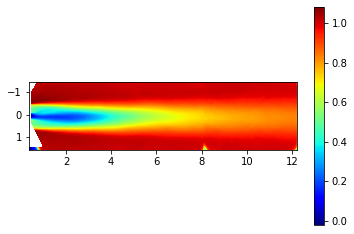

In [32]:
# Datos experimentales Bastankhah 2016

import h5py 

f = h5py.File('E:\Documents\ORGANIZADO\Tesis Eólica\Datos Bastankhah PIV(2016)\Bastankhah_jfm_2016.h5', 'r')

yaw_0 = f['Yaw_0']
yaw_10 = f['Yaw_10']
yaw_20 = f['Yaw_20']
yaw_30 = f['Yaw_30']
u_0 =yaw_0['u']['avg'][()]
u_10 =yaw_10['u']['avg'][()]
u_20 =yaw_20['u']['avg'][()]
u_30 =yaw_30['u']['avg'][()]
x = yaw_0['u']['x'][()]
x = x.reshape((-1,))
y = yaw_0['u']['y'][()]
y = y.reshape((-1,))


plt.imshow(u_0, extent= [x[0], x[-1], y[0], y[-1]], cmap='jet')
plt.colorbar()

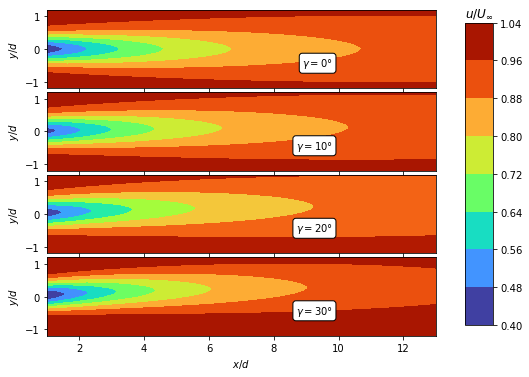

In [30]:
U = 10
yaw_ang = [0,10,20,30]
mats = []
xrange = np.linspace(1,13, 20)*D
yrange = np.linspace(-1.2,1.2)*D

sigma_0 = 0.235*D
k_w = 0.0834
y_cent = []

for yaw in yaw_ang:   
    mat = np.zeros((len(xrange),len(yrange)))
    y_c = np.zeros(len(xrange))
    for i,x in enumerate(xrange):
        for j,y in enumerate(yrange):
            mat[i,j] = Modelo_Howland(U,yaw,x,y, sigma_0, k_w)
        
        '''
        Si se desea extraer el centroide hay que modificar la función modelo Howland para que retore u, y_c_i
        y descomentar esta linea

        y_c[i] = Modelo_Howland(U,yaw,x,y, sigma_0, k_w)[1] 
        '''
    mats.append(mat)
    y_cent.append(y_c)
mat = mat[0]

figs, ax = plt.subplots(4,1, figsize=(8,6))
ax0 = ax[0].contourf(xrange/D,yrange/D, mats[0].T/U, cmap = 'turbo')
ax[0].annotate('$\gamma = 0°$', xy=(286,32), xycoords='axes points',ha='right', va='top', bbox=dict(boxstyle='round', fc='w'))
ax[0].set_ylabel('$y/d$')
# clev = np.arange(mats[1].min(),mats[1].max(),.01)
ax[1].contourf(xrange/D,yrange/D, mats[1].T/U, cmap = 'turbo')
ax[1].annotate('$\gamma = 10°$', xy=(286,32), xycoords='axes points',ha='right', va='top', bbox=dict(boxstyle='round', fc='w'))
ax[1].set_ylabel('$y/d$')
ax[2].contourf(xrange/D,yrange/D, mats[2].T/U, cmap = 'turbo')
ax[2].annotate('$\gamma = 20°$', xy=(286,32), xycoords='axes points',ha='right', va='top', bbox=dict(boxstyle='round', fc='w'))
ax[2].set_ylabel('$y/d$')
ax[3].contourf(xrange/D,yrange/D, mats[3].T/U, cmap = 'turbo')
ax[3].annotate('$\gamma = 30°$', xy=(286,32), xycoords='axes points',ha='right', va='top', bbox=dict(boxstyle='round', fc='w'))
ax[3].set_ylabel('$y/d$')
ax[3].set_xlabel('$x/d$')

'''
Graficar centroides estela
ax[0].plot(xrange/D, y_cent[0]/D, color='white', linestyle='dashed')
ax[1].plot(xrange/D, y_cent[2]/D, color='white', linestyle='dashed')
ax[2].plot(xrange/D, y_cent[2]/D, color='white', linestyle='dashed')
ax[3].plot(xrange/D, y_cent[3]/D, color='white', linestyle='dashed')
'''
# revisar metodo imshow para graficar imagen continua
# ax[1].imshow(mats[1], vmin = 0., vmax = U, cmap=plt.cm.coolwarm, origin='lower', 
        #    extent=[xrange.min(), xrange.max(), yrange.min(), yrange.max()])



# import matplotlib
# norm= matplotlib.colors.Normalize(vmin=ax0.cvalues.min(), vmax=ax0.cvalues.max())
# sm = plt.cm.ScalarMappable(norm=norm, cmap = cs.cmap)

figs.subplots_adjust(right=0.8)
figs.subplots_adjust(hspace=0.05)
cbar_ax = figs.add_axes([0.85, 0.15, 0.05, 0.7])
figs.colorbar(ax0, cax = cbar_ax)
cbar_ax.set_title('$u/U_\infty$')
# figs.colorbar(sm, cax = cbar_ax) ##continous colorbar
plt.savefig('Prediccion_angulos.png')

### Optimización


Modelo de Jensen

In [ ]:
vel_turbinas = np.array(vels.loc[:, vels.columns != 'Fecha'].iloc[0])
i = 0
vels_modelo = estela_Jensen(datos_torre['Velocidad'][i],datos_torre['Direccion'][i], 0.075)

def dif_velocidades_Jensen(kw):
    sum_ = 0
    for i in range(1050):
        vels_modelo = estela_Jensen(datos_torre['Velocidad'][i],datos_torre['Direccion'][i], kw)
        vel_turbinas = np.array(vels.loc[:, vels.columns != 'Fecha'].iloc[i])
        sum_ +=np.sum(np.abs(vels_modelo - vel_turbinas))
    return sum_


from scipy.optimize import minimize
import timeit

start = timeit.timeit()

x0 = 0.075
res = minimize(dif_velocidades_Jensen, x0)
end = timeit.timeit()


print('El valor de k_w que minimiza el error en la estela de Jensen es',res.x)
print('El tiempo de procesamiento fue de ', end - start)

El valor de k_w que minimiza el error en la estela de Jensen es [0.03413891]
El tiempo de procesamiento fue de  0.001170699999875069


Howland

In [ ]:
k_w = 0.0834
sigma_0 = 0.235*diam_turbinas

vel_turbinas = np.array(vels.loc[:, vels.columns != 'Fecha'].iloc[0])
i = 0
vels_modelo = estela_Howland(datos_torre['Velocidad'][i],datos_torre['Direccion'][i], sigma_0, k_w)

def dif_velocidades_Howland(x):
    sigma_0 = x[0]
    kw = x[1]/500
    sum_ = 0
    r = 100
    for i in range(r):
        vels_modelo = estela_Howland(datos_torre['Velocidad'][i],datos_torre['Direccion'][i], sigma_0, kw)
        vel_turbinas = np.array(vels.loc[:, vels.columns != 'Fecha'].iloc[i])
        sum_ +=np.sum(np.abs(vels_modelo - vel_turbinas))
    return sum_/r


from scipy.optimize import minimize
import time

start = time.time()

x0 = [sigma_0, k_w]
res = minimize(dif_velocidades_Howland, x0, method = 'Nelder-Mead', options={'disp': True})
end = time.time()


# print('El valor de k_w que minimiza el error es',res.x)
print(res.x)
print('El tiempo de procesamiento fue de ', end - start)

Optimization terminated successfully.
         Current function value: 14.650178
         Iterations: 199
         Function evaluations: 361
[26.90438208 10.57752915]
El tiempo de procesamiento fue de  971.0297877788544


Estimación parámetros $k_w$ y $\sigma_0$ para el parque Jepirachi. Diferencia de velocidades.

In [ ]:
cargar_datos_Jepirachi()

k_w = 0.0834
sigma_0 = 0.235*diam_turbinas

vel_turbinas = np.array(vels.loc[:, vels.columns != 'Fecha'].iloc[0])
i = 0
vels_modelo = estela_Howland(datos_torre['Velocidad'][i],datos_torre['Direccion'][i], sigma_0, k_w)

def dif_velocidades_Howland(x):
    sigma_0 = x[0]
    kw = x[1]
    sum_ = 0
    r = 1000
    for i in range(r):
        k = np.random.randint(vels.shape[0])
        # k = i
        vels_modelo = estela_Howland(datos_torre['Velocidad'][k],datos_torre['Direccion'][k], sigma_0, kw)
        vel_turbinas = np.array(vels.loc[:, vels.columns != 'Fecha'].iloc[k])
        sum_ +=np.sum(np.abs(vels_modelo - vel_turbinas))
    return sum_/r


from scipy.optimize import minimize
import time

start = time.time()

x0 = [sigma_0, k_w]
# cons = ({'type': 'ineq', 'fun': lambda x:  x[1]})
bnds = ((0,None),(0.005,0.25))


sols = []
for i in range(1):
    res = minimize(dif_velocidades_Howland, x0, method = 'Nelder-Mead', bounds = bnds, options={'disp': True})
    sols.append(res)
    print(res.x)
end = time.time()


# print('El valor de k_w que minimiza el error es',res.x)
print(sols)
print('El tiempo de procesamiento fue de ', end - start)

[13.48097351  0.08600778]
[ final_simplex: (array([[13.48097351,  0.08600778],
       [13.48097351,  0.08600778],
       [13.48097351,  0.08600778]]), array([40.88651411, 43.24070914, 43.52391791]))
           fun: 40.886514114304624
       message: 'Maximum number of function evaluations has been exceeded.'
          nfev: 400
           nit: 148
        status: 1
       success: False
             x: array([13.48097351,  0.08600778])]
El tiempo de procesamiento fue de  11257.146840333939


Estimación parámetros $k_w$ y $\sigma_0$ para el parque Jepirachi. Diferencia de potencias.

In [ ]:
cargar_datos_Jepirachi()

#adivinanzas (literatura)
k_w_adv = 0.0834 
sigma_0_adv = 0.235*diam_turbinas


def dif_Potencias_Howland(x):
    sigma_0 = x[0]
    kw = x[1]
    sum_ = 0
    r = 100
    for i in range(r):
        k = np.random.randint(pots.shape[0])
        # k = i
        vels_modelo = estela_Howland(datos_torre['Velocidad'][k],datos_torre['Direccion'][k], sigma_0, kw)
        pot_modelo = interp_pot(vels_modelo)
        pot_turbinas = np.array(pots.loc[:, pots.columns != 'Fecha'].iloc[k])
        sum_ +=np.sum(np.abs(pot_modelo - pot_turbinas))
    return sum_/r


start = time.time()

x0 = [sigma_0_adv, k_w_adv]
bnds = ((0,None),(0.005,0.25))


param_Jep_ = []
for i in range(1):
    params = minimize(dif_Potencias_Howland, x0, method = 'Nelder-Mead', bounds = bnds, options={'disp': True})
    # print(params.x)
end = time.time()


print('Los parámetros del modelo que minimizan el error son $k_w = $',params.x[1],'y $\sigma_0 =$',params.x[0])
print('El tiempo de procesamiento fue de ', end - start)

Los parámetros del modelo que minimizan el error son $k_w = $ 0.08735585609436039 y $\sigma_0 =$ 13.877326240539553
El tiempo de procesamiento fue de  1127.153730392456


In [ ]:
pd.cut(vels_coquito, np.arange(25)).value_counts()
pd.cut(dirs_coquito, np.arange(36)*10).value_counts()


(0, 10]         129
(10, 20]        181
(20, 30]        301
(30, 40]        602
(40, 50]       1458
(50, 60]       5194
(60, 70]      15653
(70, 80]      25371
(80, 90]      24776
(90, 100]      9118
(100, 110]     1708
(110, 120]      641
(120, 130]      305
(130, 140]      189
(140, 150]      154
(150, 160]       83
(160, 170]       80
(170, 180]       69
(180, 190]       43
(190, 200]       45
(200, 210]       56
(210, 220]       53
(220, 230]       49
(230, 240]       58
(240, 250]       73
(250, 260]       70
(260, 270]       71
(270, 280]      110
(280, 290]      127
(290, 300]      117
(300, 310]      130
(310, 320]      115
(320, 330]      135
(330, 340]      148
(340, 350]      126
dtype: int64

In [ ]:
###maximizar potencia

sigma_0 = 0.235*D
k_w = 0.044


start = time.time()

x0 = [0]*len(lat_turbinas_m)
opts = []
vels_ = [8.5,9.5,10.5,11.5]
dirs = np.arange(37*2-1)*5
for U in vels_:
    for dir in dirs:
        res = minimize(Potencia_Howland, x0, method = 'Nelder-Mead', args=(U,dir), options={'disp': True})
        opts.append(res)
end = time.time()


# print('El valor de k_w que minimiza el error es',res.x)
print(res.x)
print('El tiempo de ')


Optimization terminated successfully.
         Current function value: 48790.000000
         Iterations: 3
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 48790.000000
         Iterations: 3
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 48790.000000
         Iterations: 3
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 48790.000000
         Iterations: 3
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 48790.000000
         Iterations: 3
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 48790.000000
         Iterations: 3
         Function evaluations: 155
Optimization terminated successfully.
         Current function value: 48790.000000
         Iterations: 3
         Function evaluations: 155
Optimi

Pregunta: cómo es la diferencia en velocidades para el problema de optimización planteado en términos absolutos o en términos de enteros (integer optimization)

$n!$ = número posible de permutaciones de $n$ numeros
$50!/13! ~ 10e55$
not feasible to brute force 

In [ ]:
cargar_datos_Jepirachi()

###maximizar potencia

sigma_0 = 0.235*D
k_w = 0.0834

def pot(v, yaw):
    return [interp_pot(v[i])*cos(radians(yaw[i]))**2.2 for i in range(len(v))]

def Potencia_Howland(yaw_vec, U, dir):
    yaw_vec = np.array(yaw_vec)
    vels = estela_Howland(U, dir, yaw_vec = yaw_vec)
    pots = pot(vels, yaw_vec)
    return -sum(pots)



start = time.time()

x0 = [0]*len(lat_turbinas_m)
U = 13
dirs = [180+5, 180 + 15, 180 + 25]
opt_Jepirachi_2_2 = []
pot_eff = np.zeros(len(dirs))
bnds = ((-30,30),(-30,30))*(len(long_turbinas_m)//2)+((30,30),)
for i,dir in enumerate(dirs):
    res = minimize(Potencia_Howland, x0, method = 'L-BFGS-B', args=(U,dir), bounds=bnds, options={'disp': True})
    opt_Jepirachi_2_2.append(res)
    pot_opt = Potencia_Howland(res.x, U, dirs[i])
    pot_0 = Potencia_Howland([0]*len(lat_turbinas_m), U, dirs[i])
    # print(opt_pots_1_8[i].x)
    pot_eff[i] = pot_opt/pot_0
    print(pot_eff[i])
end = time.time()


# print('El valor de k_w que minimiza el error es',res.x)
print(res.x)
print('El tiempo de ')

0.9821699022102485
0.9817261395248762
0.9819429668457802
[-2.15595508e-01  8.44108692e-03 -1.18693429e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -3.10863334e-04  0.00000000e+00
  0.00000000e+00  0.00000000e+00  3.00000000e+01]
El tiempo de 


Ángulos más comunes Coquito

In [ ]:
cargar_datos_Coquito()

###maximizar potencia

sigma_0 = 0.235*D
k_w = 0.0834


x0 = [0]*len(lat_turbinas_m)
U = 8.5
dirs = [180-5,180,180+5,180+10,180+15,180+20,180+25]
Coquito_2_2_freq = []
pot_eff = np.zeros(len(dirs))
bnds = ((-30,30),(-30,30))*(len(long_turbinas_m)//2)
for i,dir in enumerate(dirs):
    
    start = time.time()

    res = minimize(Potencia_Howland, x0, method = 'L-BFGS-B', args=(U,dir), bounds=bnds, options={'disp': True})

    end = time.time()
    Coquito_2_2_freq.append(res)
    pot_opt = Potencia_Howland(res.x, U, dirs[i])
    pot_0 = Potencia_Howland([0]*len(lat_turbinas_m), U, dirs[i])
    # print(opt_pots_1_8[i].x)
    pot_eff[i] = pot_opt/pot_0
    print('Optimización para ángulo ', dir,', tiempo de procesamiento = ', end-start, ' s',
        'Power ratio gain = ', pot_eff[i])


Optimización para ángulo  175 , tiempo de procesamiento =  320.7464563846588  s Power ratio gain =  1.000532828599
Optimización para ángulo  180 , tiempo de procesamiento =  17.293198347091675  s Power ratio gain =  1.0
Optimización para ángulo  185 , tiempo de procesamiento =  310.6883053779602  s Power ratio gain =  1.0005328288069206
Optimización para ángulo  190 , tiempo de procesamiento =  399.40909934043884  s Power ratio gain =  1.0000100229523914
Optimización para ángulo  195 , tiempo de procesamiento =  289.63429045677185  s Power ratio gain =  1.0000085117855764
Optimización para ángulo  200 , tiempo de procesamiento =  423.0510399341583  s Power ratio gain =  1.0008371216285314
Optimización para ángulo  205 , tiempo de procesamiento =  489.9166600704193  s Power ratio gain =  1.0009555228826077
Optimización para ángulo  180 , tiempo de procesamiento =  15.268567323684692  s Power ratio gain =  1.0


In [ ]:
for i in range(len(opts)):
    print(np.round(opts[i].x,3))

[1.506 1.458 1.458 1.458 1.457 1.458 1.461 1.457 1.457 1.458 1.532 1.48
 1.483 1.48  1.481 1.482 1.483 1.481 1.481 1.493 1.417 1.412 1.411 1.41
 1.409 1.41  1.411 1.411 1.409 1.534 1.281 1.284 1.282 1.282 1.281 1.283
 1.283 1.281 1.283 1.468 0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.   ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[-1.459 -1.456 -1.456 -1.456 -1.457 -1.456 -1.456 -1.456 -1.457 -1.505
 -1.492 -1.48  -1.479 -1.479 -1.481 -1.48  -1.481 -1.479 -1.48  -1.533
 -1.533 -1.409 -1.409 -1.409 -1.41  -1.409 -1.411 -1.41  -1.41  -1.418
 -1.469 -1.281 -1.281 -1.281 -1.281 -1.282 -1.283 -1.283 -1.283 -1.282
  0.     0.     0.     0.     0.     0.     0.     0.     0.     0.   ]
[ 0.221  0.224  0.224  0.222  0.222  0.227  0.229  0.224  0.201 -0.034
  0.193  0.23   0.231  0.23   0.23   0.234  0.234  0.233  0.225 -0.001
  0.233  0.279  0.279  0.279  0.277  0.281  0.2

Text(0, 0.5, '$P(\\gamma_{opt})/P(\\gamma=0) - 1$ (%)')

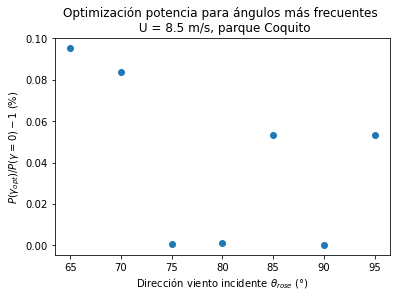

In [ ]:
U = 8.5
dirs = [180-5,180,180+5,180+10,180+15,180+20,180+25]
theta_r = 270 - np.array(dirs)
pot_eff = np.zeros(len(dirs))
for i in range(len(dirs)):
    pot_opt = Potencia_Howland(opts[i].x, U, dirs[i])
    pot_0 = Potencia_Howland([0]*len(lat_turbinas_m), U, dirs[i])
    # print(opt_pots_1_8[i].x)
    pot_eff[i] = pot_opt/pot_0

fig, ax = plt.subplots()
ax.scatter(theta_r, (pot_eff-1)*100)
ax.set_title('Optimización potencia para ángulos más frecuentes \n U = 8.5 m/s, parque Coquito')
ax.set_xlabel(r'Dirección viento incidente $\theta_{rose}$ (°)')
ax.set_ylabel('$P(\gamma_{opt})/P(\gamma=0) - 1$ (%)')

Angulos de interés Coquito

In [ ]:
cargar_datos_Coquito()

###maximizar potencia

sigma_0 = 0.235*D
k_w = 0.0834

def pot(v, yaw):
    return [interp_pot(v[i])*cos(radians(yaw[i]))**2.2 for i in range(len(v))]

def Potencia_Howland(yaw_vec, U, dir):
    yaw_vec = np.array(yaw_vec)
    vels = estela_Howland(U, dir, yaw_vec = yaw_vec)
    pots = pot(vels, yaw_vec)
    return -sum(pots)



start = time.time()

x0 = [0]*len(lat_turbinas_m)
U = 8.5
dirs = [80, 82.5, 85, 87.5 ,90]
opt_Coquito_2_2 = []
pot_eff = np.zeros(len(dirs))
bnds = ((-30,30),(-30,30))*(len(long_turbinas_m)//2)
for i,dir in enumerate(dirs):
    start = time.time()

    res = minimize(Potencia_Howland, x0, method = 'L-BFGS-B', args=(U,dir), bounds=bnds, options={'disp': True})

    end = time.time()
    opt_Coquito_2_2.append(res)
    pot_opt = Potencia_Howland(res.x, U, dirs[i])
    pot_0 = Potencia_Howland([0]*len(lat_turbinas_m), U, dirs[i])
    # print(opt_pots_1_8[i].x)
    pot_eff[i] = pot_opt/pot_0
    print('Optimización para ángulo ', dir,', tiempo de procesamiento = ', end-start, ' s',
        'Power ratio gain = ', pot_eff[i])

Optimización para ángulo  80 , tiempo de procesamiento =  301.9826674461365  s Power ratio gain =  1.0010422649099235
Optimización para ángulo  82.5 , tiempo de procesamiento =  514.1503190994263  s Power ratio gain =  1.0115897118879578
Optimización para ángulo  85 , tiempo de procesamiento =  701.3276228904724  s Power ratio gain =  1.0469720691498643
Optimización para ángulo  87.5 , tiempo de procesamiento =  669.9859304428101  s Power ratio gain =  1.1366049967431624
Optimización para ángulo  90 , tiempo de procesamiento =  15.166225671768188  s Power ratio gain =  1.0


In [ ]:
for i in range(len(opt_Coquito_2_2)):
    print(np.round(opt_Coquito_2_2[i].x,3))

[0.    1.792 1.803 1.802 1.806 1.803 1.794 1.793 1.795 1.751 0.    1.792
 1.803 1.802 1.804 1.803 1.794 1.793 1.795 1.75  0.    1.792 1.803 1.802
 1.806 1.803 1.794 1.793 1.795 1.75  0.    1.793 1.804 1.802 1.804 1.802
 1.792 1.791 1.794 1.749 0.    1.794 1.805 1.802 1.805 1.804 1.793 1.79
 1.794 1.75 ]
[0.    5.59  5.702 5.706 5.712 5.708 5.688 5.686 5.693 5.247 0.    5.59
 5.702 5.706 5.712 5.708 5.688 5.686 5.692 5.247 0.    5.59  5.702 5.706
 5.713 5.708 5.689 5.687 5.693 5.247 0.    5.59  5.702 5.705 5.712 5.709
 5.687 5.686 5.693 5.248 0.    5.589 5.702 5.706 5.712 5.708 5.688 5.685
 5.693 5.247]
[ 0.    12.088 12.479 12.536 12.562 12.562 12.539 12.54  12.606 10.618
  0.    12.088 12.479 12.536 12.562 12.561 12.539 12.539 12.605 10.617
  0.    12.088 12.479 12.535 12.561 12.562 12.539 12.539 12.605 10.618
  0.    12.088 12.479 12.536 12.562 12.562 12.54  12.54  12.607 10.618
  0.    12.088 12.479 12.536 12.561 12.561 12.54  12.539 12.604 10.618]
[ 0.    16.773 17.649 17.86  17.95

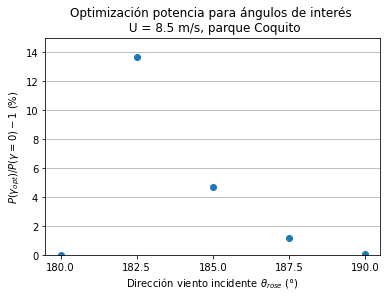

In [ ]:

U = 8.5
dirs = [80, 82.5, 85, 87.5 ,90]
theta_r = 270 - np.array(dirs)
pot_eff = np.zeros(len(dirs))
for i in range(len(dirs)):
    pot_opt = Potencia_Howland(opt_Coquito_2_2[i].x, U, dirs[i])
    pot_0 = Potencia_Howland([0]*len(lat_turbinas_m), U, dirs[i])
    # print(opt_pots_1_8[i].x)
    pot_eff[i] = pot_opt/pot_0

fig, ax = plt.subplots()
ax.scatter(theta_r, (pot_eff-1)*100)
ax.yaxis.grid(which='both')
ax.set_ybound(0,15)
ax.set_title('Optimización potencia para ángulos de interés \n U = 8.5 m/s, parque Coquito')
ax.set_xlabel(r'Dirección viento incidente $\theta_{rose}$ (°)')
ax.set_ylabel('$P(\gamma_{opt})/P(\gamma=0) - 1$ (%)')
ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(2.5))

Text(0, 0.5, '$y/d$')

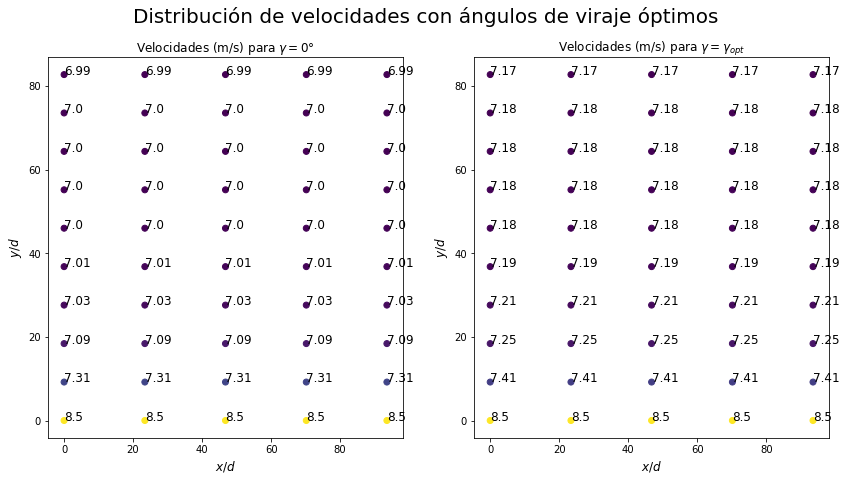

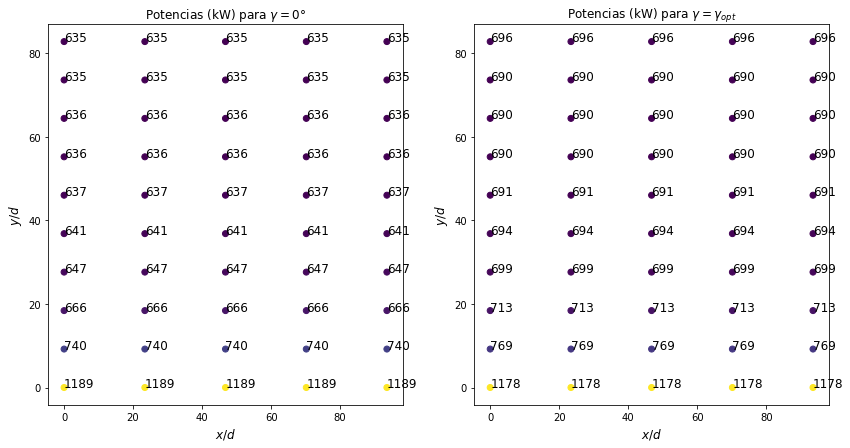

In [ ]:
ang_int = 182.5
dir = 270 - ang_int
U = 8.5

#extraer sol optima
yaw_opt = opt_Coquito_2_2[1].x
yaw_0 = [0]*len(lat_turbinas_m)

vel_yaw_0 = estela_Howland(U,dir, yaw_vec = yaw_0)
vel_yaw_opt = estela_Howland(U,dir, yaw_vec = yaw_opt)

fig,ax = plt.subplots(1,2, figsize=(14,7))

## TODO revisar grafica de turbinas con marker=verts
# alpha = np.radians(dir) - np.pi/2 - np.array([0]*len(lat_turbinas_m))
# x1 = - 1/2*np.cos(alpha) 
# y1 = 1/2*np.sin(alpha)
# x2 = 1/2*np.cos(alpha)
# y2 = - 1/2*np.sin(alpha)
# verts = [[(x1[i],x2[i]),(y2[i],y1[i])] for i in range(len(x1))]
# verts = list(zip([x1,x2],[y2,y1]))

ax[0].scatter(np.array(long_turbinas_m)/D, np.array(lat_turbinas_m)/D, c = vel_yaw_0)
ax[0].set_title(r'Velocidades (m/s) para $\gamma = 0°$')
ax[1].set_title(r'Velocidades (m/s) para $\gamma = \gamma_{opt}$')
for i, txt in enumerate(vel_yaw_0):
    ax[0].annotate(round(vel_yaw_0[i],2), (long_turbinas_m[i]/D, lat_turbinas_m[i]/D), size= 12)
ax[1].scatter(np.array(long_turbinas_m)/D, np.array(lat_turbinas_m)/D, c = vel_yaw_opt)
for i, txt in enumerate(vel_yaw_opt):
    ax[1].annotate(round(vel_yaw_opt[i],2), (long_turbinas_m[i]/D, lat_turbinas_m[i]/D), size= 12)

ax[0].set_xlabel('$x/d$', fontsize=12)
ax[0].set_ylabel('$y/d$', fontsize=12)
ax[1].set_xlabel('$x/d$', fontsize=12)
ax[1].set_ylabel('$y/d$', fontsize=12)
fig.suptitle('Distribución de velocidades con ángulos de viraje óptimos', fontsize=20)


def pot(v, yaw):
    return [interp_pot(v[i])*cos(radians(yaw[i]))**2.2 for i in range(len(v))]


fig,ax = plt.subplots(1,2, figsize=(14,7))

pot_yaw_0 = pot(vel_yaw_0, yaw_0)
pot_yaw_opt = pot(vel_yaw_opt, yaw_opt)

vel_yaw_0 = pot_yaw_0 ##unicamente para graficar
vel_yaw_opt = pot_yaw_opt ##unicamente para graficar

ax[0].scatter(np.array(long_turbinas_m)/D, np.array(lat_turbinas_m)/D, c = vel_yaw_0)
ax[0].set_title(r'Potencias (kW) para $\gamma = 0°$')
for i, txt in enumerate(vel_yaw_0):
    ax[0].annotate(int(vel_yaw_0[i]), (long_turbinas_m[i]/D, lat_turbinas_m[i]/D), size= 12)
ax[1].scatter(np.array(long_turbinas_m)/D, np.array(lat_turbinas_m)/D, c = vel_yaw_opt)
ax[1].set_title(r'Potencias (kW) para $\gamma = \gamma_{opt}$')
for i, txt in enumerate(vel_yaw_opt):
    ax[1].annotate(int(vel_yaw_opt[i]), (long_turbinas_m[i]/D, lat_turbinas_m[i]/D), size= 12)

ax[0].set_xlabel('$x/d$', fontsize=12)
ax[0].set_ylabel('$y/d$', fontsize=12)
ax[1].set_xlabel('$x/d$', fontsize=12)
ax[1].set_ylabel('$y/d$', fontsize=12)


Parque imaginario, para hacer pruebas

In [ ]:
#parque imaginario

long_turbinas_m = [0,0]
lat_turbinas_m = [0, 2*D]

###maximizar potencia

sigma_0 = 0.235*D
k_w = 0.0834

def pot(v, yaw):
    return [interp_pot(v[i])*cos(radians(yaw[i]))**2.2 for i in range(len(v))]

def Potencia_Howland(yaw_vec, U, dir):
    yaw_vec = np.array(yaw_vec)
    vels = estela_Howland(U, dir, yaw_vec = yaw_vec)
    pots = pot(vels, yaw_vec)
    return -sum(pots)



start = time.time()

x0 = [25]*len(lat_turbinas_m)
U = 10
dirs = [90]
opt_imag = []
bnds = ((-30,30),(-30,30))
for i,dir in enumerate(dirs):
    res = minimize(Potencia_Howland, x0, method = 'L-BFGS-B', args=(U,dir), bounds=bnds, options={'disp': True})
    pot_opt = Potencia_Howland(res.x, U, dirs[i])
    pot_0 = Potencia_Howland([0]*len(lat_turbinas_m), U, dirs[i])
    # print(opt_pots_1_8[i].x)
    pot_eff = pot_opt/pot_0
    print(pot_eff)
end = time.time()


# print('El valor de k_w que minimiza el error es',res.x)
print(res.x)
print('El tiempo de ')

0.9999999999989515
[ 1.07146987e-04 -4.20565582e-05]
El tiempo de 


In [ ]:
estela_Howland(U,dir, 0)
bnds = ((-30,30),(-30,30))*(len(long_turbinas_m)//2)+((30,30),)
print(bnds)
print(long_turbinas_m)

C:\Users\user\AppData\Local\Temp/ipykernel_59472/926517113.py:36: RuntimeWarning: divide by zero encountered in double_scalars
  u = U - delta_u_i*D**2/(8*sigma_0_i**2)*exp(-(y - y_c_i)**2/(2*sigma_0_i**2*dw**2))
C:\Users\user\AppData\Local\Temp/ipykernel_59472/926517113.py:36: RuntimeWarning: invalid value encountered in double_scalars
  u = U - delta_u_i*D**2/(8*sigma_0_i**2)*exp(-(y - y_c_i)**2/(2*sigma_0_i**2*dw**2))
C:\Users\user\AppData\Local\Temp/ipykernel_59472/926517113.py:35: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  y_c_i = integrate.quad(integrand, x0, x)[0]


((-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (30, 30))
[1508.2746799999295, 1334.8381200000094, 1145.5941199998572, 967.5934399999913, 789.704080000042, 638.7541599999034, 470.10435999996037, 304.68283999997414, 1190.1221199999513, 1009.2271199998785, 813.081279999948, 621.9448400000257, 416.11416000002686, 214.84759999997385, 0.0]


In [ ]:

###maximizar potencia

sigma_0 = 0.235*D
k_w = 0.0834

def pot(v, yaw):
    return [interp_pot(v[i])*cos(radians(yaw[i]))**2 for i in range(len(v))]

def Potencia_Howland(yaw_vec, U, dir):
    yaw_vec = np.array(yaw_vec)
    vels = estela_Howland(U, dir, yaw_vec = yaw_vec)
    pots = pot(vels, yaw_vec)
    return sum(pots)



start = time.time()

x0 = [0]*len(lat_turbinas_m)
U = 8.5
dir = 90
bnds = ((-30,30),(-30,30))*(len(long_turbinas_m)//2)
res_Coq = minimize(Potencia_Howland, x0, method = 'Nelder-Mead', args=(U,dir), bounds = bnds, options={'disp': True})

end = time.time()


print(res.x)
print('El tiempo de ')


In [ ]:
#### ADAM



def Maximize_Power(k_w, sigma_0, gamma_0, alpha, beta_1, beta_2, eps):
    


((-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30), (-30, 30))


In [ ]:
cargar_datos_Coquito()

###maximizar potencia

sigma_0 = 0.235*D
k_w = 0.0834

def pot(v, yaw):
    return [interp_pot(v[i])*cos(radians(yaw[i]))**2.5 for i in range(len(v))]

def Potencia_Howland(yaw_vec, U, dir):
    yaw_vec = np.array(yaw_vec)
    vels = estela_Howland(U, dir, yaw_vec = yaw_vec)
    pots = pot(vels, yaw_vec)
    return sum(pots)



start = time.time()

x0 = [0]*len(lat_turbinas_m)
v = 8.5
dirsssss = [80,90,100]
sols_coquito_2 = []
for U in velsssss:
    for dir in dirsssss:
        res = minimize(Potencia_Howland, x0, method = 'Nelder-Mead', args=(U,dir), options={'disp': True})
        sols_coquito_2.append(res)
end = time.time()


# print('El valor de k_w que minimiza el error es',res.x)
print(res.x)
print('El tiempo de ')

### Visualización del campo de velocidades en granja

In [68]:


#Visualizacion viento en granja

def upwind_(x,y,dir):
    """
    Retorna una lista booleana con 1 si el punto x,y está aguas arriba de la turbina k 
        y 0 de lo contrario
    """
    lat, lon = np.array(lat_turbinas_m), np.array(long_turbinas_m)
    xi, yi = x-lon, y-lat
    return np.where(cos(np.arctan2(yi,xi) - radians(dir)) > 0, 1,0)


def inside_Jensen_(x,y,dir, kw=kw):
    """
    Retorna una lista booleana con 1 si el punto x,y está dentro de la estela de la turbina k 
        y 0 de lo contrario, con el modelo de Jensen
    """

    x_rel = x-np.array(long_turbinas_m)
    y_rel = y-np.array(lat_turbinas_m)
    r = sqrt(x_rel**2+y_rel**2)
    omega = np.arctan2(y,x) - radians(dir)
    xbar = r*cos(omega)
    ybar = r*sin(omega)

    r_w =  D/2 + kw*np.abs(ybar) #radius of wake
    return (xbar>0) & (np.abs(ybar)< r_w + D/2)


def calcular_campo_velocidades(xrange, yrange, U, yaw, dir):
    
    
    mat = np.zeros((len(yrange),len(xrange)))
    if isinstance(yaw,int) | isinstance(yaw,float):
        yaw = [yaw]*len(lat_turbinas_m)
    dir = dir % 360
    vel = estela_Howland(U,dir,yaw_vec=yaw)
    for i,x in enumerate(xrange):
        for j,y in enumerate(yrange):
            delta = []
            for k in range(len(lat_turbinas_m)):
                if upwind_(x,y,dir)[k]==1:
                    R = sqrt((x-long_turbinas_m[k])**2 + (y-lat_turbinas_m[k])**2)
                    if dir<180:
                        phi = np.arctan2((x-long_turbinas_m[k]),(y-lat_turbinas_m[k]))
                        x_rel, y_rel = R*cos(phi-radians(dir)), R*sin(phi-radians(dir))
                    elif dir>180:
                        phi = np.arctan2((y-lat_turbinas_m[k]),(x-long_turbinas_m[k]))
                        x_rel, y_rel = R*cos(-phi+radians(dir)), R*sin(-phi+radians(dir))
                    delta_j_i = vel[k] - Modelo_Howland(vel[k],yaw[k],x_rel,y_rel)
                    delta.append(delta_j_i)
            vel_xy = U - sqrt(np.sum(np.square(delta)))
            mat[j,i] = vel_xy
    return mat

def calcular_campo_velocidades_lineal(xrange, yrange, U, dir, parque):
    
    
    mat = np.zeros((len(yrange),len(xrange)))
    dir = dir % 360
    vel = estela_Koch(U,dir)
    for i,x in enumerate(xrange):
        for j,y in enumerate(yrange):
            delta = []
            for k in range(len(lat_turbinas_m)):
                if upwind_(x,y,dir)[k]==1:
                    R = sqrt((x-long_turbinas_m[k])**2 + (y-lat_turbinas_m[k])**2)
                    if dir<180:
                        phi = np.arctan2((x-long_turbinas_m[k]),(y-lat_turbinas_m[k]))
                        x_rel, y_rel = R*cos(phi-radians(dir)), R*sin(phi-radians(dir))
                    elif dir>180:
                        phi = np.arctan2((y-lat_turbinas_m[k]),(x-long_turbinas_m[k]))
                        x_rel, y_rel = R*cos(-phi+radians(dir)), R*sin(-phi+radians(dir))
                    delta_j_i = estela_Jensen_singular(vel[k],dir, x-long_turbinas_m[k],y-lat_turbinas_m[k], parque, kw=0.04)
                    delta.append(delta_j_i)
            vel_xy = U*(1 - sqrt(np.sum(np.square(delta))))
            mat[j,i] = vel_xy
    return mat



Text(0, 0.5, 'y (m)')

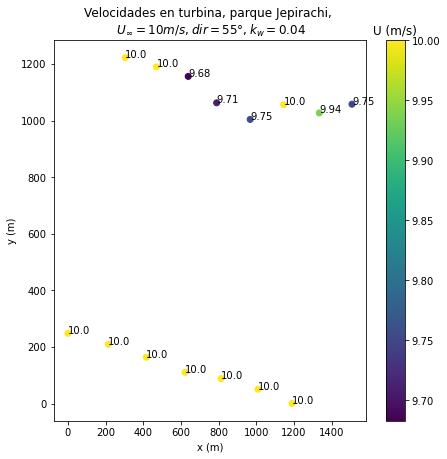

In [119]:
pintar_velocidades_parque(estela_Koch(10,55))
ax = plt.gca()
cb = ax.collections[-1].colorbar
cb.ax.set_title('U (m/s)')
ax.set_title('Velocidades en turbina, parque Jepirachi, \n $U_\infty=10 m/s, dir = 55°, k_w = 0.04$')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')


In [78]:

## Eleccion parametros a graficar
cargar_datos_Jepirachi()
U = 10
dir = -90
xrange = np.linspace(0,long_turbinas_m[0]+100,250)
yrange = np.linspace(-300,lat_turbinas_m[0]+200, 250)

mat = calcular_campo_velocidades_lineal(xrange,yrange, U, dir,'Jepirachi')


Text(0, 0.5, 'y (m)')

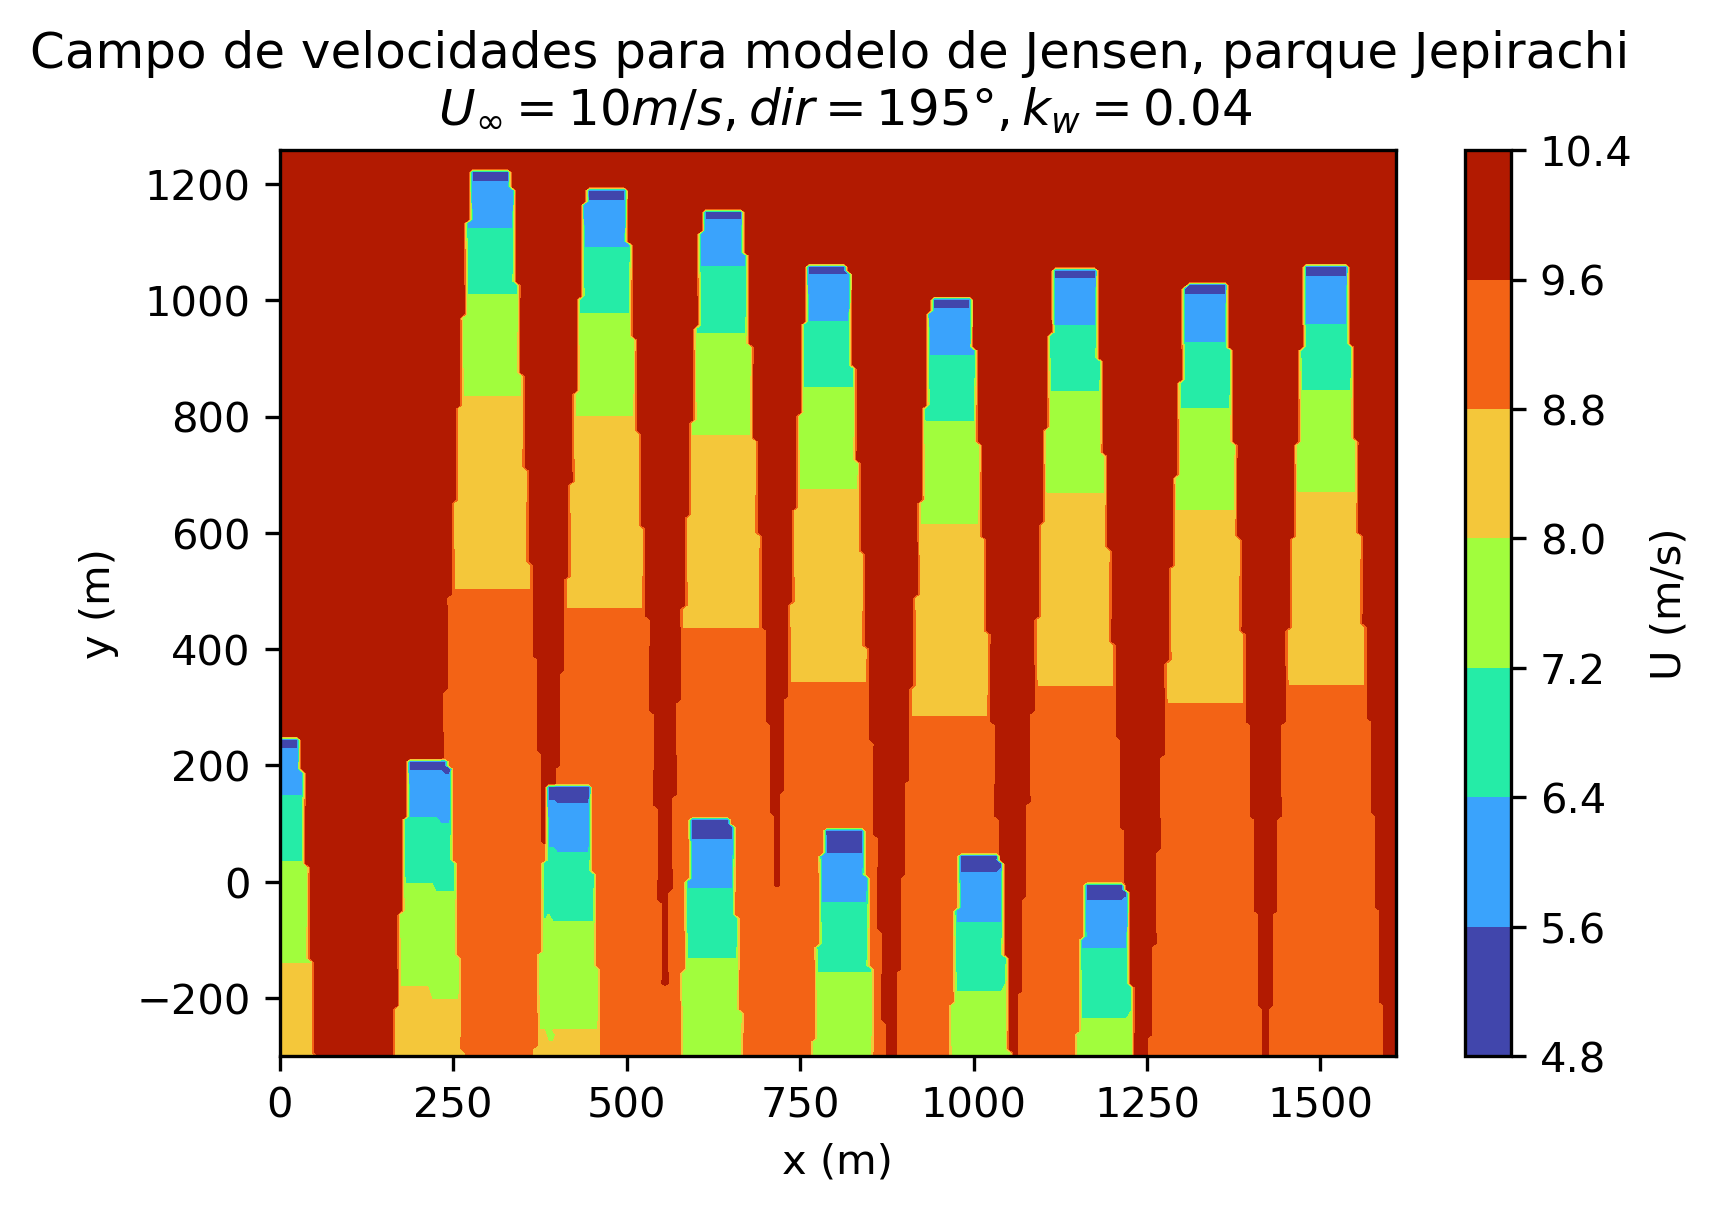

In [79]:
plt.rcParams['figure.dpi']=300
plt.contourf(xrange,yrange, mat, cmap='turbo')
cb = plt.colorbar()
cb.set_label('U (m/s)')
ax = plt.gca()
ax.set_title('Campo de velocidades para modelo de Jensen, parque Jepirachi \n $U_\infty = 10 m/s, dir = 195°, k_w = 0.04 $')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')
# plt.scatter(long_turbinas_m,lat_turbinas_m)
# mat_yaw = calcular_campo_velocidades(xrange,yrange, U, 30, dir)

# figs, ax = plt.subplots(1,2, figsize=(14,7), dpi=300)
# ax0 = ax[0].contourf(xrange,yrange, mat, cmap = 'turbo')
# ax1 = ax[1].contourf(xrange,yrange, mat_yaw, cmap = 'turbo')
# ax.set_ylabel('$y/d$')


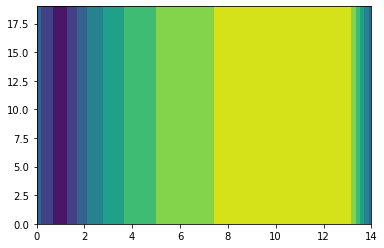

In [38]:
plt.contourf(mat)

1.5707963267948966


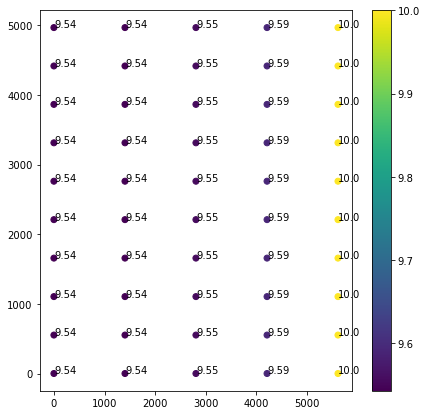

In [ ]:
pintar_velocidades_parque(estela_Howland(U,180))
print(np.arctan2(1,0))

Text(0.5, 1.0, 'Estela parque Jepirachi modelo Shapiro \n $U=8.5, dir=270°-182.5°, \\gamma=\\gamma_{opt}°$')

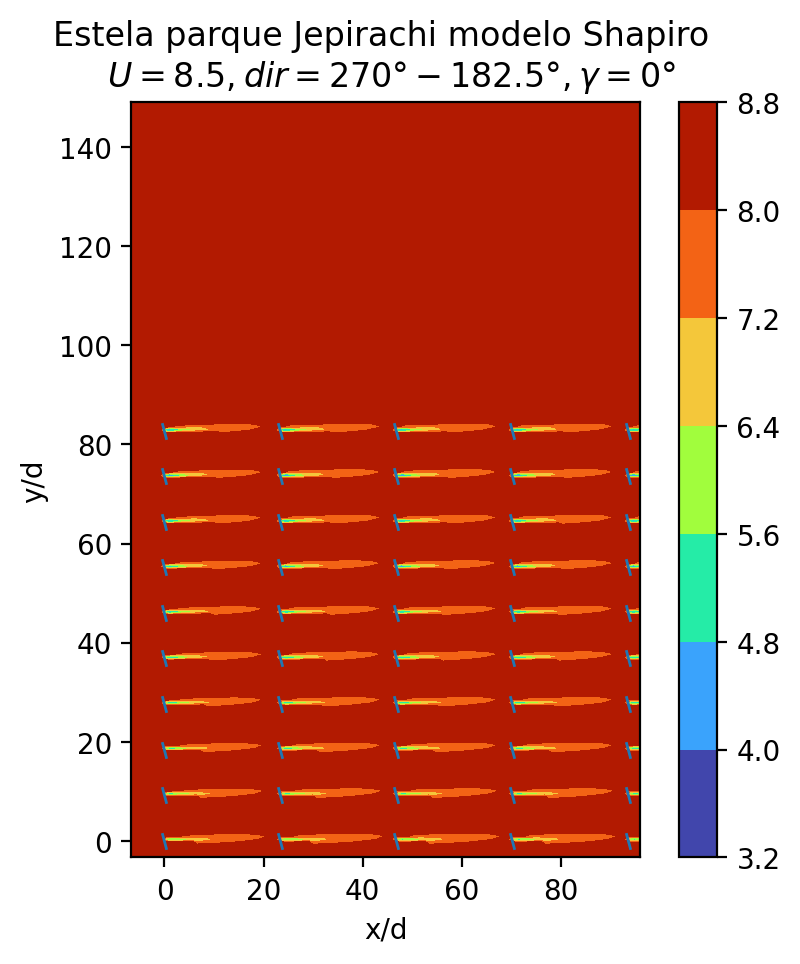

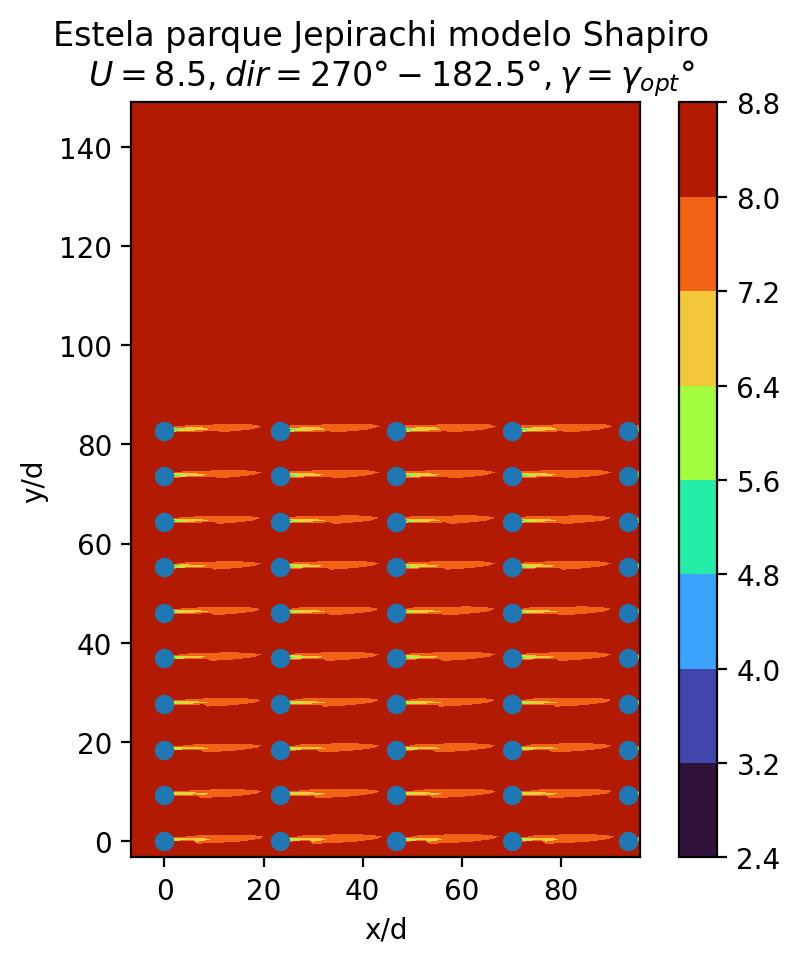

In [ ]:

U = 8.5
dir = 270-182.5
xrange = np.linspace(0-400,long_turbinas_m[0]+150,150)
yrange = np.linspace(-200, 1.8*lat_turbinas_m[0], 250)

mat = calcular_campo_velocidades(xrange, yrange, U, 0, dir)
mat_yaw = calcular_campo_velocidades(xrange, yrange, U, yaw_opt, dir)



fig, ax = plt.subplots(figsize=(5,5), dpi=200)

ax1 = ax.contourf(xrange/D, yrange/D, mat, cmap='turbo')

dir = 180+15
alpha = np.radians(dir) - np.pi/2
x1 = - 1/2*np.cos(alpha) 
y1 = 1/2*np.sin(alpha)
x2 = 1/2*np.cos(alpha)
y2 = - 1/2*np.sin(alpha)
verts = list(zip([x1,x2],[y2,y1]))

ax.scatter(np.array(long_turbinas_m)/D,np.array(lat_turbinas_m)/D, marker=verts)
ax.set_aspect('equal')
cb1=fig.colorbar(ax1,ax=ax)
ax.set_xlabel('x/d')
ax.set_ylabel('y/d')
ax.set_title('Estela parque Jepirachi modelo Shapiro \n $U=8.5, dir=270°-182.5°, \gamma=0°$')

fig2, ax2 = plt.subplots(figsize=(5,5), dpi=200)
ax_2 = ax2.contourf(xrange/D, yrange/D, mat_yaw, cmap='turbo')

alpha = np.radians(dir) - np.pi/2 - radians(30)
x1 = - 1/2*np.cos(alpha) 
y1 = 1/2*np.sin(alpha)
x2 = 1/2*np.cos(alpha)
y2 = - 1/2*np.sin(alpha)
verts = list(zip([x1,x2],[y2,y1]))

ax2.scatter(np.array(long_turbinas_m)/D,np.array(lat_turbinas_m)/D)
ax2.set_aspect('equal')
cb2=fig2.colorbar(ax_2,ax=ax2)
cb2.mappable.set_clim(*cb1.mappable.get_clim())
ax2.set_xlabel('x/d')
ax2.set_ylabel('y/d')
ax2.set_title('Estela parque Jepirachi modelo Shapiro \n $U=8.5, dir=270°-182.5°, \gamma=\gamma_{opt}°$')

Text(0.5, 1.0, 'Modelo de estela de Jensen/Koch')

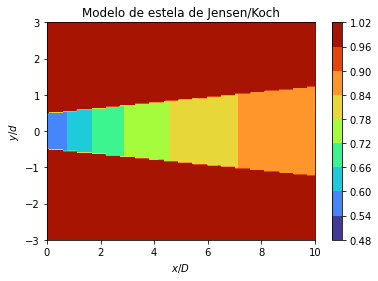

In [ ]:
U = 10
dir = 0
mats = []
xrange = np.linspace(0,10*D,250)
yrange = np.linspace(-3*D,3*D, 150)

mat_Jensen = np.zeros((len(xrange),len(yrange)))
for i,x in enumerate(xrange):
    for j,y in enumerate(yrange):
        
        Ct = calcular_Ct(U)
        phi = radians(dir)
        gamma = np.arctan2(y,x)
        r = sqrt(x**2+y**2)
        omega = phi - gamma
        xbar = r*sin(omega)
        ybar = r*cos(omega)
        turbinas_afectadas = (xbar<D/2+kw*ybar) & (xbar>-D/2-kw*ybar) & (ybar>0)

        mat_Jensen[i,j] = np.where(turbinas_afectadas == 0, U, U*(1-(1-np.sqrt(1-Ct))/(1+2*kw*ybar/diam_turbinas)**2))

figs, ax = plt.subplots()
ax0 = ax.contourf(xrange/D,yrange/D, mat_Jensen.T/U, cmap='turbo')
figs.colorbar(ax0)
ax.set_xlabel('$x/D$')
ax.set_ylabel('$y/d$')
ax.set_title('Modelo de estela de Jensen/Koch')


Text(0.5, 1.0, 'Modelo de estela de Shapiro/Howland')

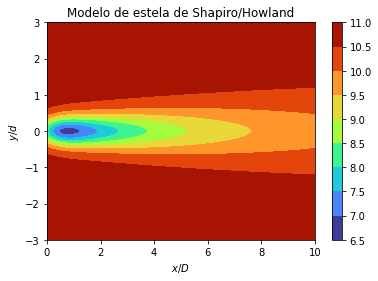

In [633]:
U = 10
dir = 0
yaw = 0
mats = []
xrange = np.linspace(0,10*D,250)
yrange = np.linspace(-3*D,3*D, 150)

mat_Howland = np.zeros((len(xrange),len(yrange)))
for i,x in enumerate(xrange):
    for j,y in enumerate(yrange):
        mat_Howland[i,j] = Modelo_Howland(U,yaw,x,y)

mat_Howland = mat_Howland*4/6 + 24/6
figs, ax = plt.subplots()
ax0 = ax.contourf(xrange/D,yrange/D, mat_Howland.T, cmap='turbo')
figs.colorbar(ax0)
ax.set_xlabel('$x/D$')
ax.set_ylabel('$y/d$')
ax.set_title('Modelo de estela de Shapiro/Howland')


TypeError: Input z must be at least a (2, 2) shaped array, but has shape (1, 2)

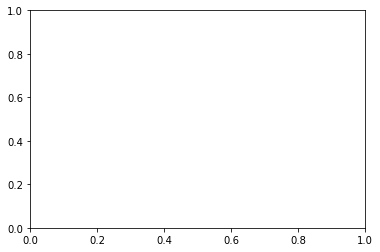

In [640]:
img = plt.(np.array([[6,10]]), cmap="turbo")
img.set_visible(False)

plt.colorbar(orientation="vertical")

Text(0, 0.5, '$y/d$')

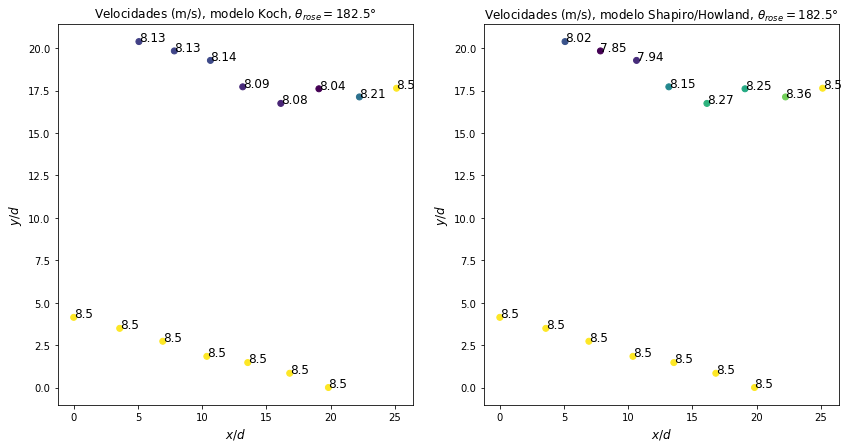

In [626]:
ang_int = 182.5
dir = 270 - ang_int
U = 8.5

yaw_0 = [0]*len(lat_turbinas_m)

vel_Jen = estela_Koch(U,dir)
vel_How = estela_Howland(U,dir, yaw_vec = yaw_0)

fig,ax = plt.subplots(1,2, figsize=(14,7))

alpha = np.radians(dir) - np.pi/2 
x1 = - 1/2*np.cos(alpha) 
y1 = 1/2*np.sin(alpha)
x2 = 1/2*np.cos(alpha)
y2 = - 1/2*np.sin(alpha)
verts = list(zip([x1,x2],[y2,y1]))

ax[0].scatter(np.array(long_turbinas_m)/D, np.array(lat_turbinas_m)/D, c = vel_Jen)
ax[1].scatter(np.array(long_turbinas_m)/D, np.array(lat_turbinas_m)/D, c = vel_How)
ax[0].set_title(r'Velocidades (m/s), modelo Koch, $\theta_{rose}=182.5°$')
ax[1].set_title(r'Velocidades (m/s), modelo Shapiro/Howland, $\theta_{rose}=182.5°$')
for i, txt in enumerate(vel_Jen):
    ax[0].annotate(round(vel_Jen[i],2), (long_turbinas_m[i]/D, lat_turbinas_m[i]/D), size= 12)
for i, txt in enumerate(vel_How):
    ax[1].annotate(round(vel_How[i],2), (long_turbinas_m[i]/D, lat_turbinas_m[i]/D), size= 12)

ax[0].set_xlabel('$x/d$', fontsize=12)
ax[0].set_ylabel('$y/d$', fontsize=12)
ax[1].set_xlabel('$x/d$', fontsize=12)
ax[1].set_ylabel('$y/d$', fontsize=12)

In [29]:
cargar_datos_Coquito()

In [33]:
%%timeit -r 4 -n 10

U = 10
dir = 90
vel = estela_Howland(U,dir)


329 ms ± 9.33 ms per loop (mean ± std. dev. of 4 runs, 10 loops each)
